In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd
import os

In [2]:

# sampling frequency from paper
fs = 2000
ninapro_root = "./Ninapro/DB1"
print(os.path.abspath(ninapro_root))

all_emg = {}
all_data = {}
for filename in os.listdir(ninapro_root):
    if filename.endswith("A1_E1.mat"):
        full_path = os.path.join(ninapro_root, filename)

        subject_id = filename.split("_")[0]  # "S1", "S2", ...

        mat = loadmat(full_path)
        emg = mat["emg"]
        all_data[subject_id] = mat
        all_emg[subject_id] = emg

print(all_emg.keys())
print(all_data['S1'].keys())
# dictionary with all subject emgs

/data/Ninapro/DB1
dict_keys(['S2', 'S1', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27'])
dict_keys(['__header__', '__version__', '__globals__', 'emg', 'stimulus', 'glove', 'subject', 'exercise', 'repetition', 'restimulus', 'rerepetition'])


## 1) Visualization and Preprocessing

In [3]:
# faire comme Part1 mais pour tous les subjects, à mon avis faudra virer des channels
# y'en aura forcément qui sont pas bien

all_processed = {}

for subject in all_data.keys():

    data = all_data[subject]

    # Extract variables for this subject
    emg_rectified = data["emg"].copy()
    stimulus = data["restimulus"].squeeze()
    repetition = data["rerepetition"].squeeze()

    # Store them
    all_processed[subject] = {
        "emg": emg_rectified,
        "stimulus": stimulus,
        "repetition": repetition
    }
    # Print basic info for this subject
    #print(f"Subject: {subject}")
    #print(f"  EMG shape:        {emg_rectified.shape}")
    #print(f"  Stimulus shape:   {stimulus.shape}")
    #print(f"  Repetition shape: {repetition.shape}")
    #print("-" * 40)

In [4]:
N_STIMULI = 12  
N_REPETITIONS = 10 

MOV_MEAN_LENGTH = 25
MOV_MEAN_WEIGHTS = np.ones(MOV_MEAN_LENGTH) / MOV_MEAN_LENGTH

for subject in all_processed.keys():
    
    data = all_processed[subject]
    emg_rectified = data["emg"]
    stimulus = data["stimulus"]
    repetition = data["repetition"]


    emg_windows = [[None for repetition_idx in range(N_REPETITIONS)] for stimuli_idx in range(N_STIMULI)]
    emg_envelopes = [[None for repetition_idx in range(N_REPETITIONS)] for stimuli_idx in range(N_STIMULI)]
    
    for stimuli_idx in range(N_STIMULI):
        for repetition_idx in range(N_REPETITIONS):
            current_stimulus = stimuli_idx + 1
            current_repetition = repetition_idx + 1
            
            idx = np.logical_and(stimulus == current_stimulus, repetition == current_repetition)
            
            window = emg_rectified[idx, :]
            
            if window.shape[0] > 0:
                emg_windows[stimuli_idx][repetition_idx] = window
                
                emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(
                    window, 
                    MOV_MEAN_WEIGHTS, 
                    axis=0
                )
    
    all_processed[subject]["emg_windows"] = emg_windows
    all_processed[subject]["emg_envelopes"] = emg_envelopes
    #print(f"Preprocess finish for {subject}.")
    #print("-" * 40)

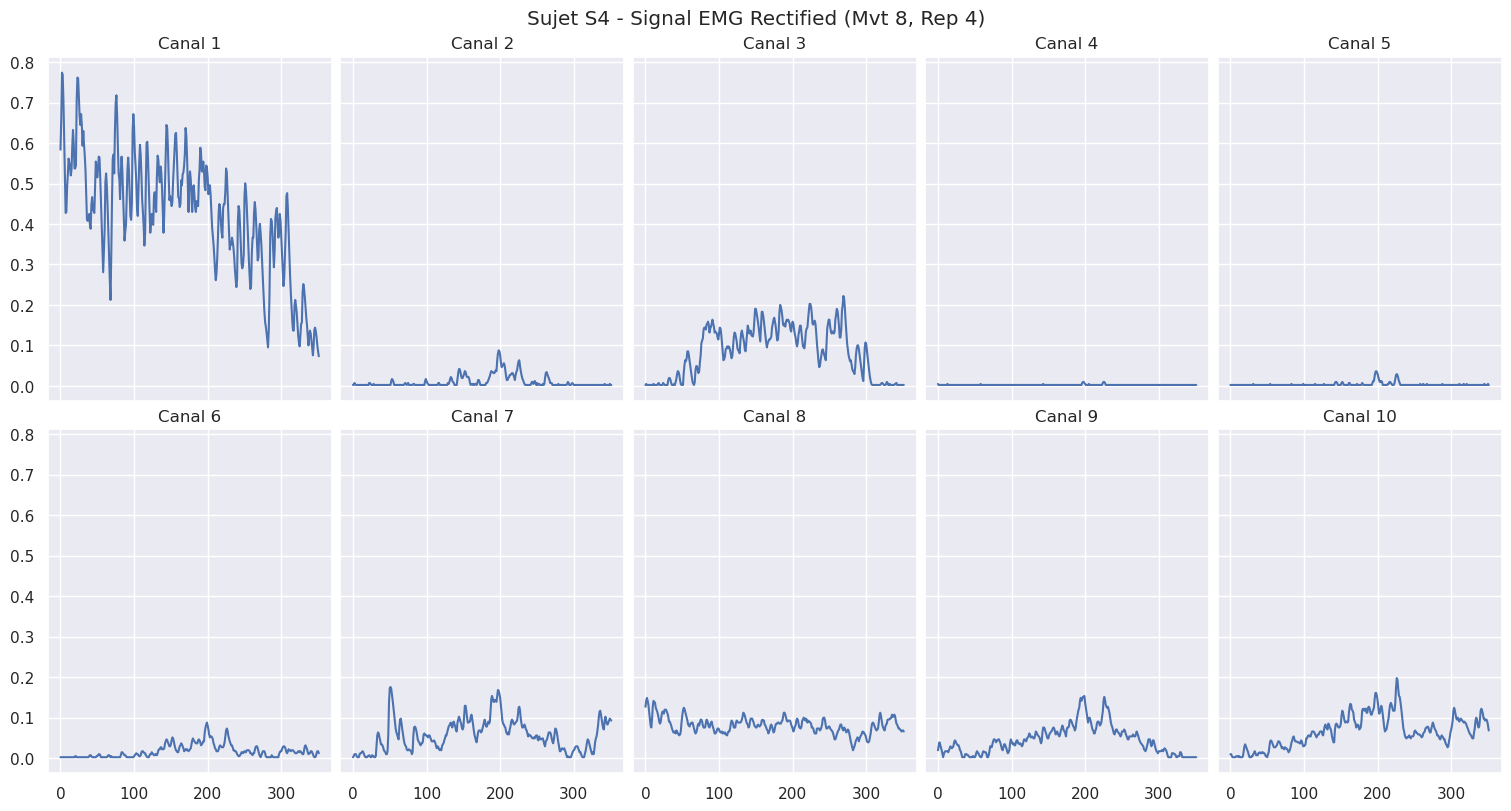

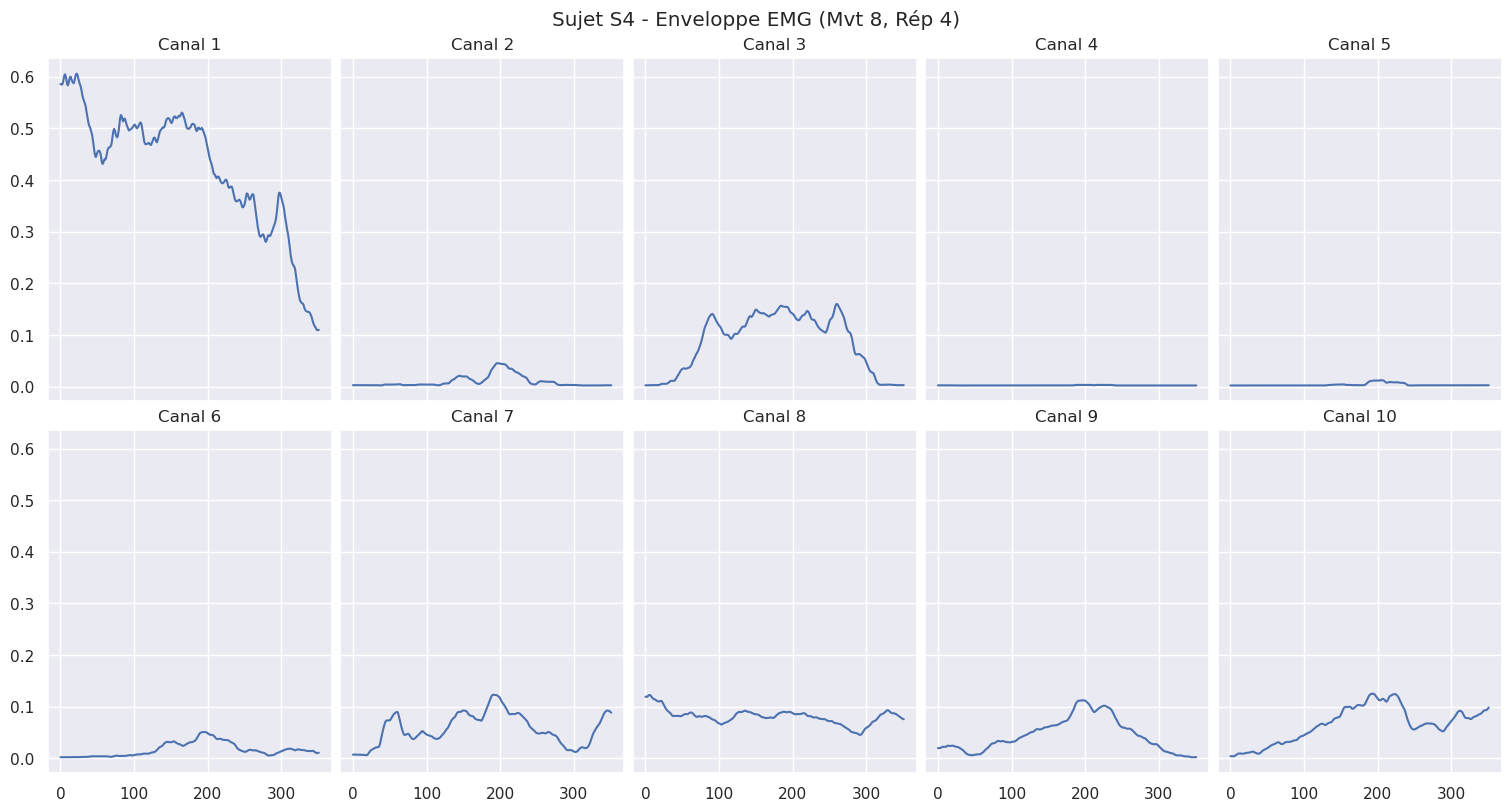

In [5]:
SUBJECT_TO_PLOT = 'S4'
STIMULUS_INDEX_TO_PLOT = 7
REPETITION_INDEX_TO_PLOT = 3

if SUBJECT_TO_PLOT in all_processed:
    windows_data = all_processed[SUBJECT_TO_PLOT]["emg_windows"]
    envelopes_data = all_processed[SUBJECT_TO_PLOT]["emg_envelopes"]
    
    emg_window = windows_data[STIMULUS_INDEX_TO_PLOT][REPETITION_INDEX_TO_PLOT]
    emg_envelope = envelopes_data[STIMULUS_INDEX_TO_PLOT][REPETITION_INDEX_TO_PLOT]
    
    if emg_window is not None:
        number_of_emg_channels = emg_window.shape[1] 

        fig, ax = plt.subplots(2, 5, figsize=(15, 8), constrained_layout=True, sharex=True, sharey=True)
        ax = ax.ravel()
        for channel_idx in range(number_of_emg_channels): 
            ax[channel_idx].plot(emg_window[:, channel_idx])
            ax[channel_idx].set_title(f"Canal {channel_idx+1}")
        plt.suptitle(f"Sujet {SUBJECT_TO_PLOT} - Signal EMG Rectified (Mvt {STIMULUS_INDEX_TO_PLOT+1}, Rep {REPETITION_INDEX_TO_PLOT+1})")
        plt.show() 

        fig, ax = plt.subplots(2, 5, figsize=(15, 8), constrained_layout=True, sharex=True, sharey=True)
        ax = ax.ravel()
        for channel_idx in range(number_of_emg_channels): 
            ax[channel_idx].plot(emg_envelope[:, channel_idx])
            ax[channel_idx].set_title(f"Canal {channel_idx+1}")
        plt.suptitle(f"Sujet {SUBJECT_TO_PLOT} - Enveloppe EMG (Mvt {STIMULUS_INDEX_TO_PLOT+1}, Rép {REPETITION_INDEX_TO_PLOT+1})")
        plt.show()

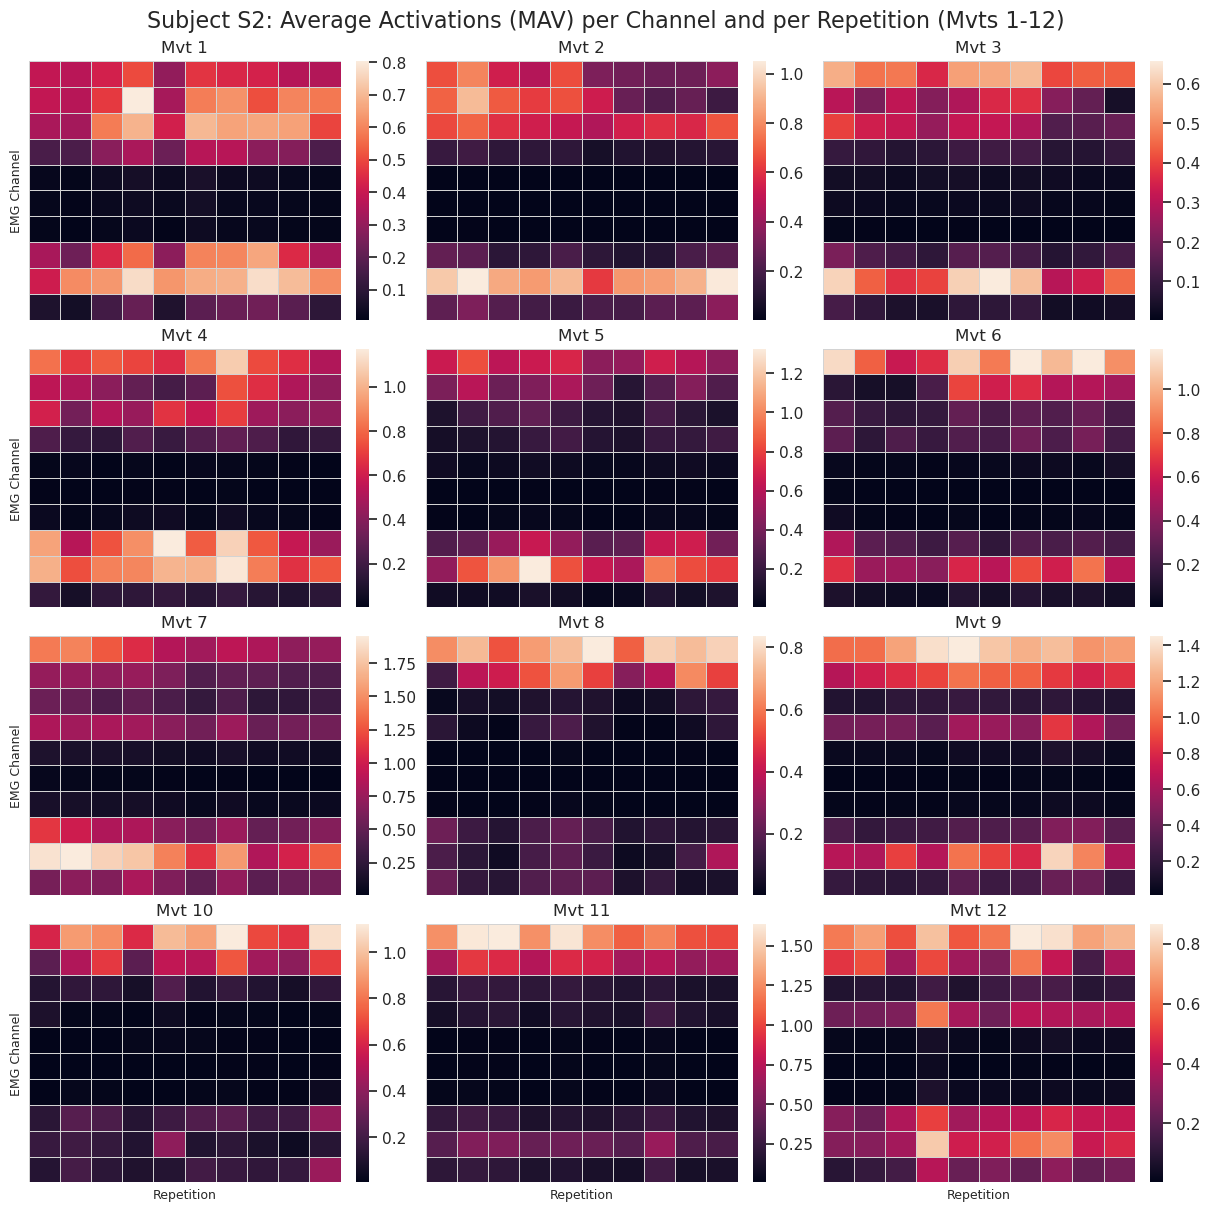

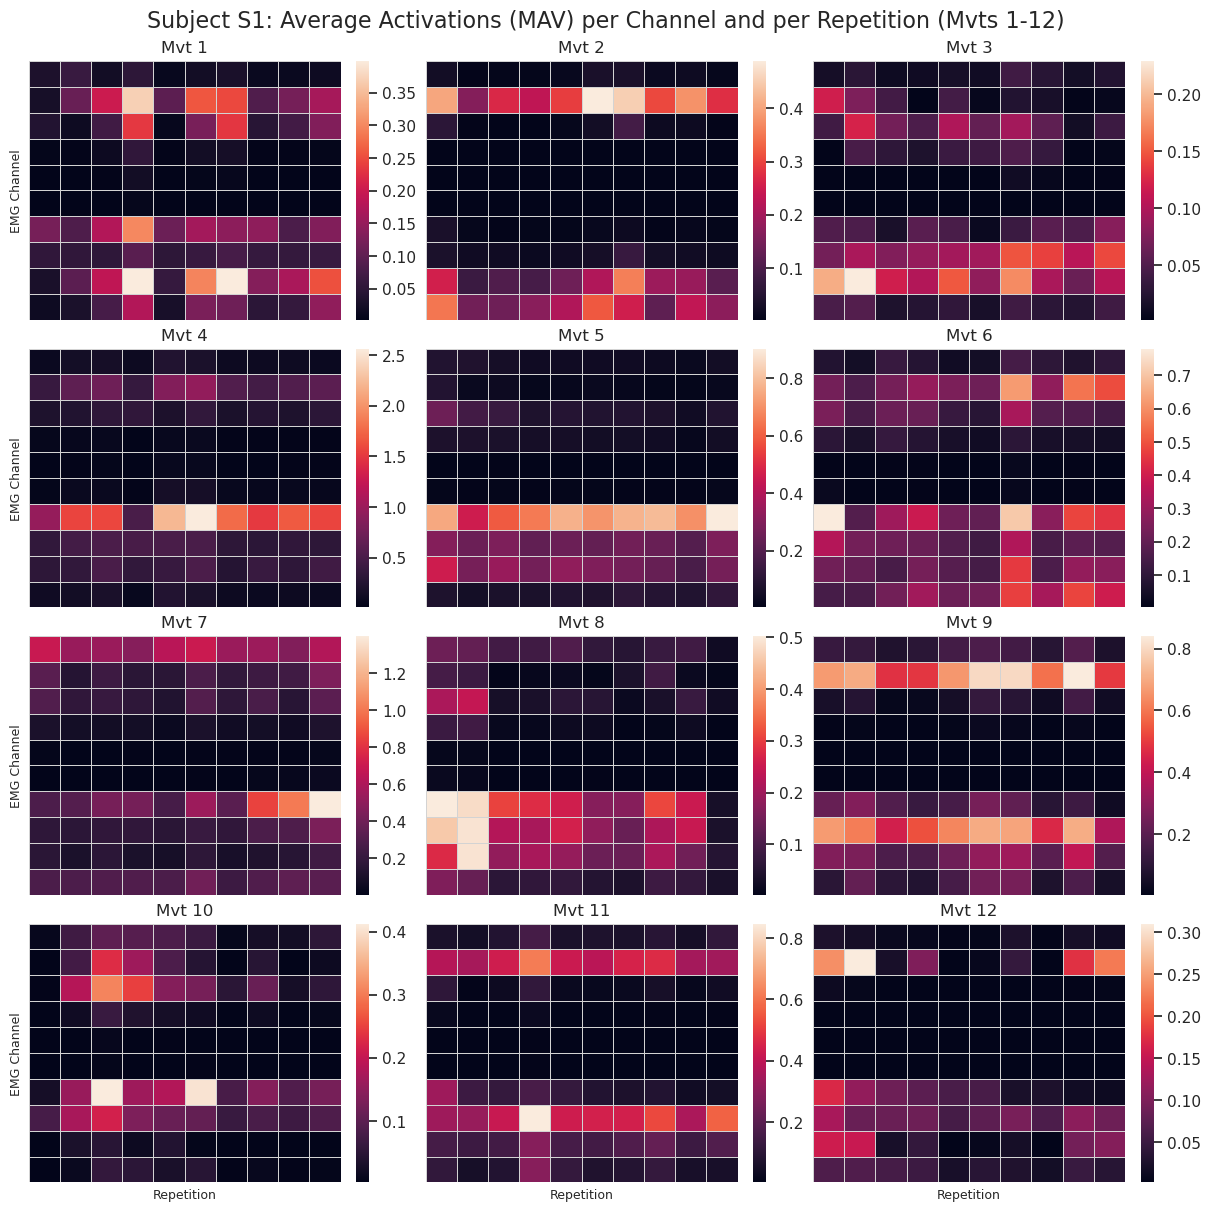

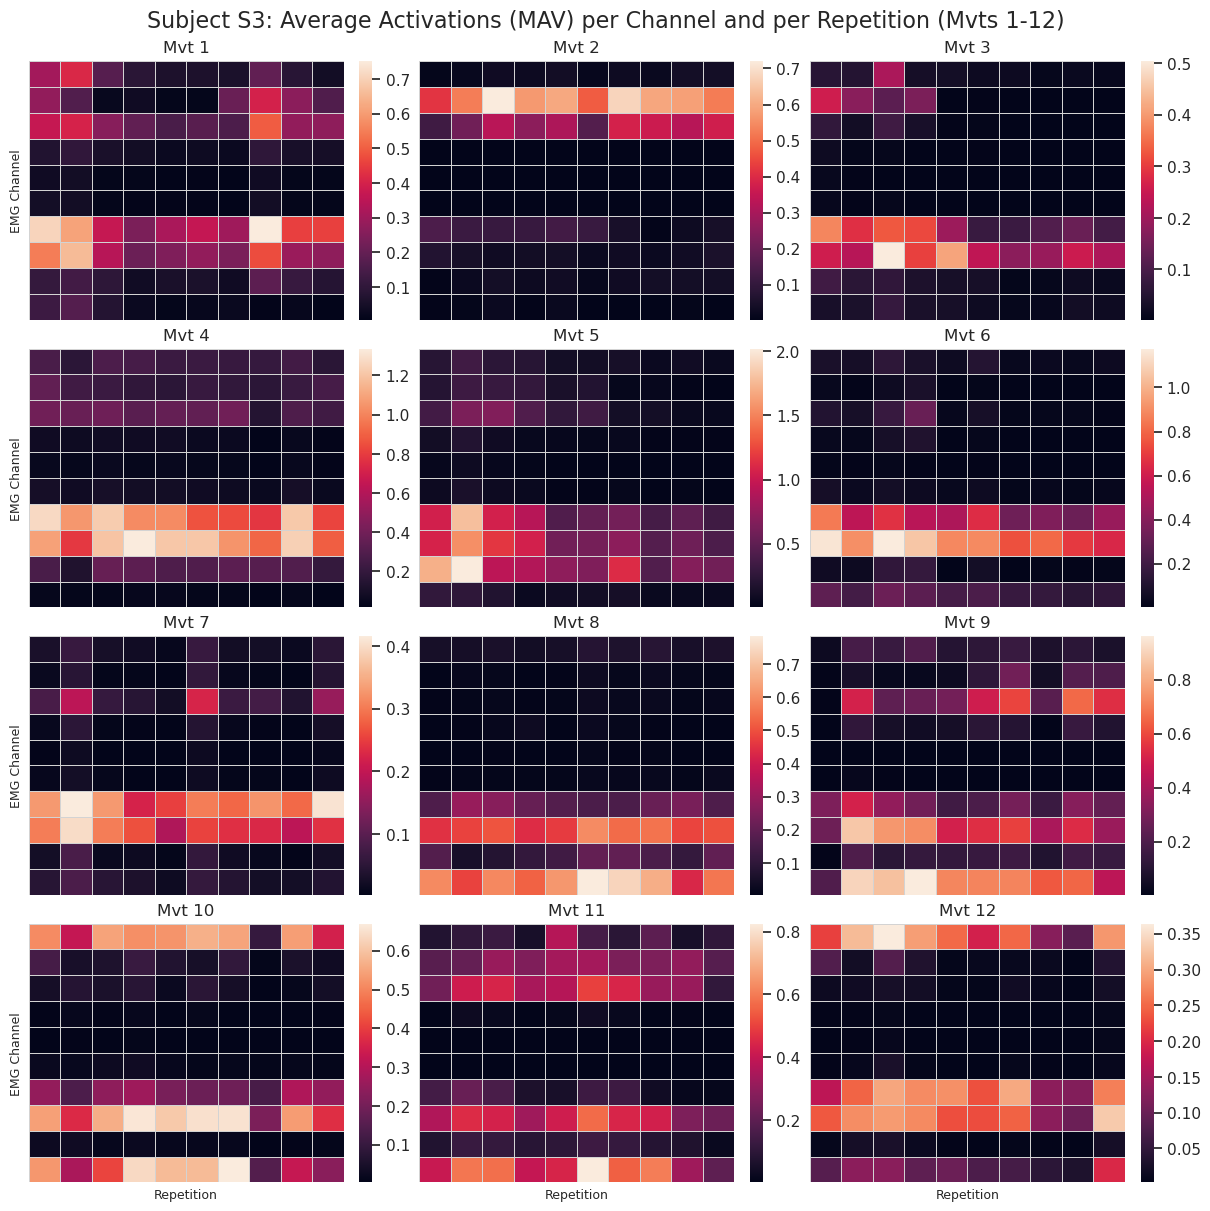

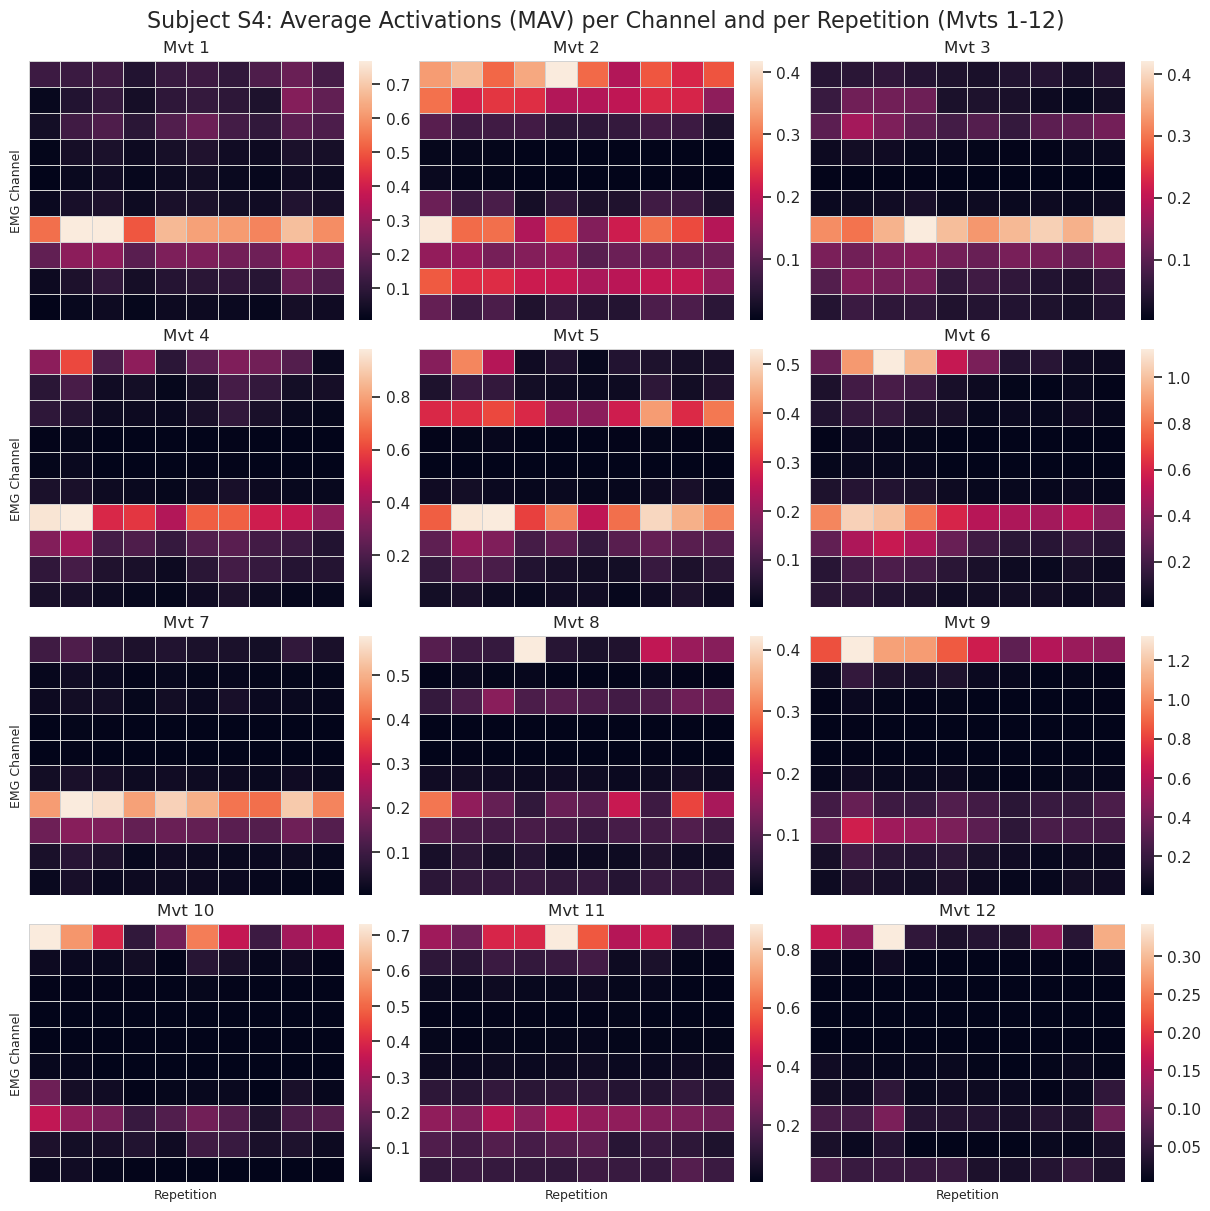

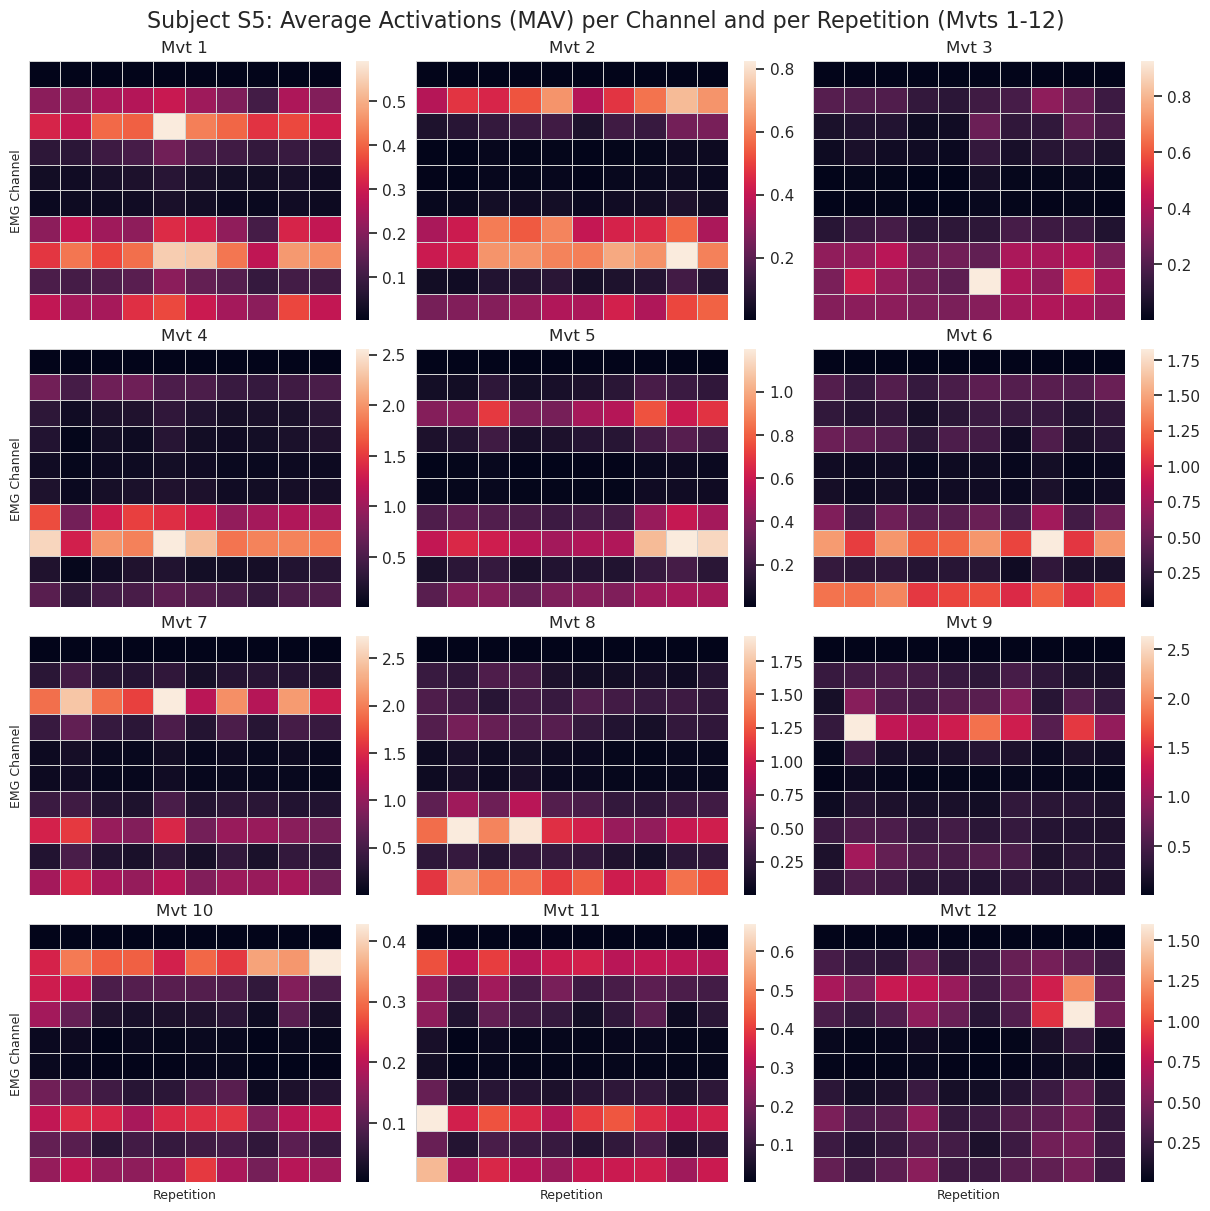

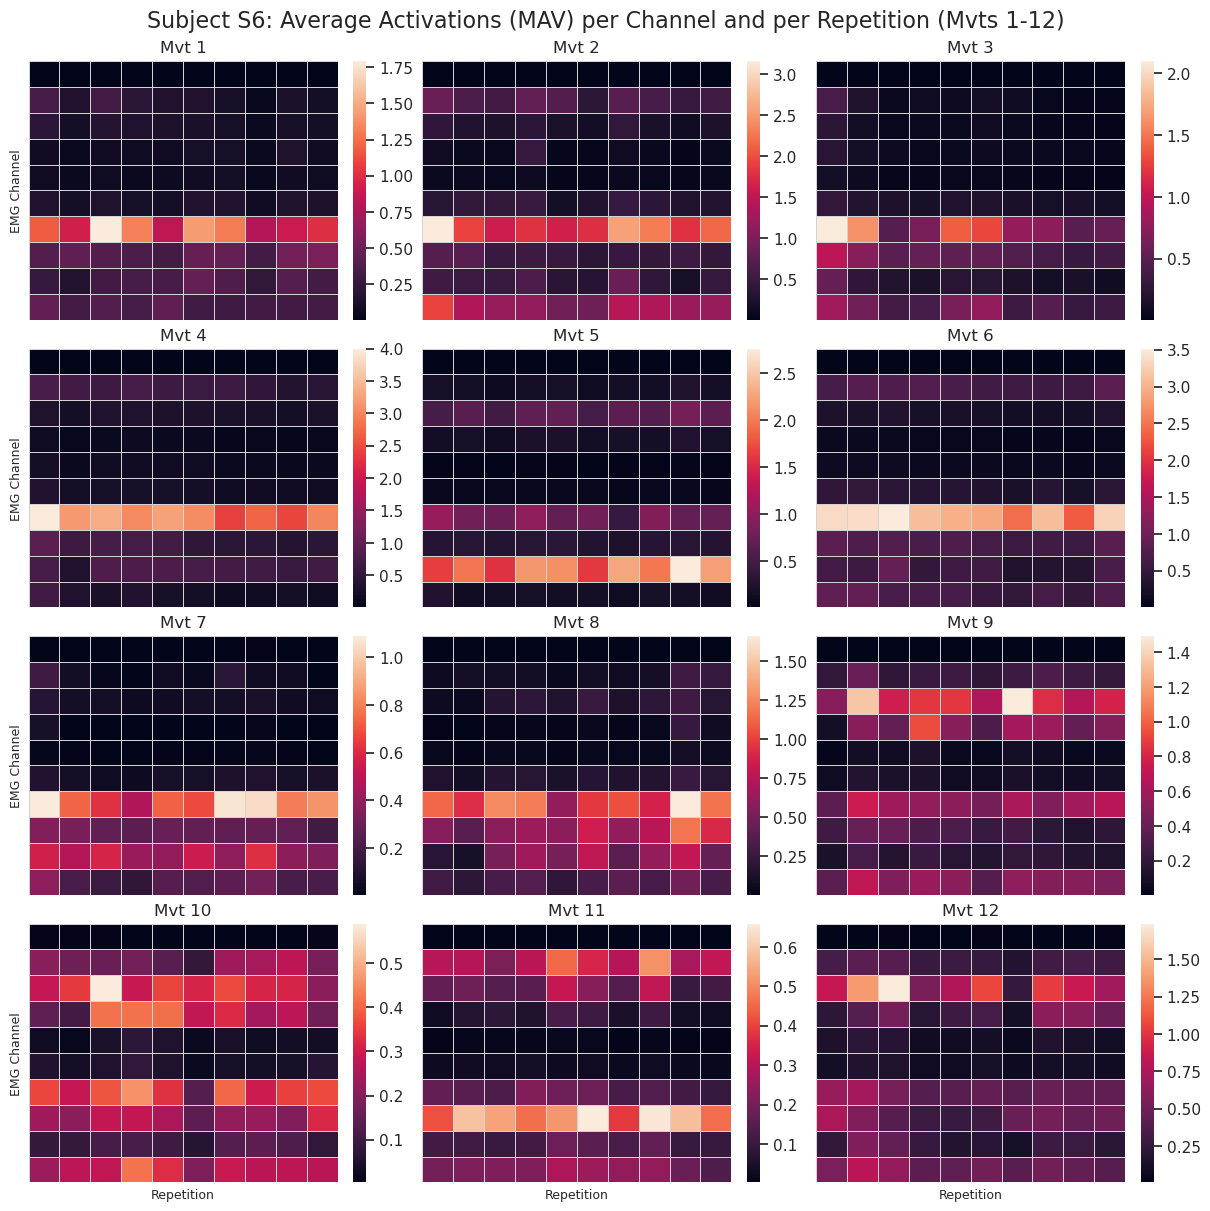

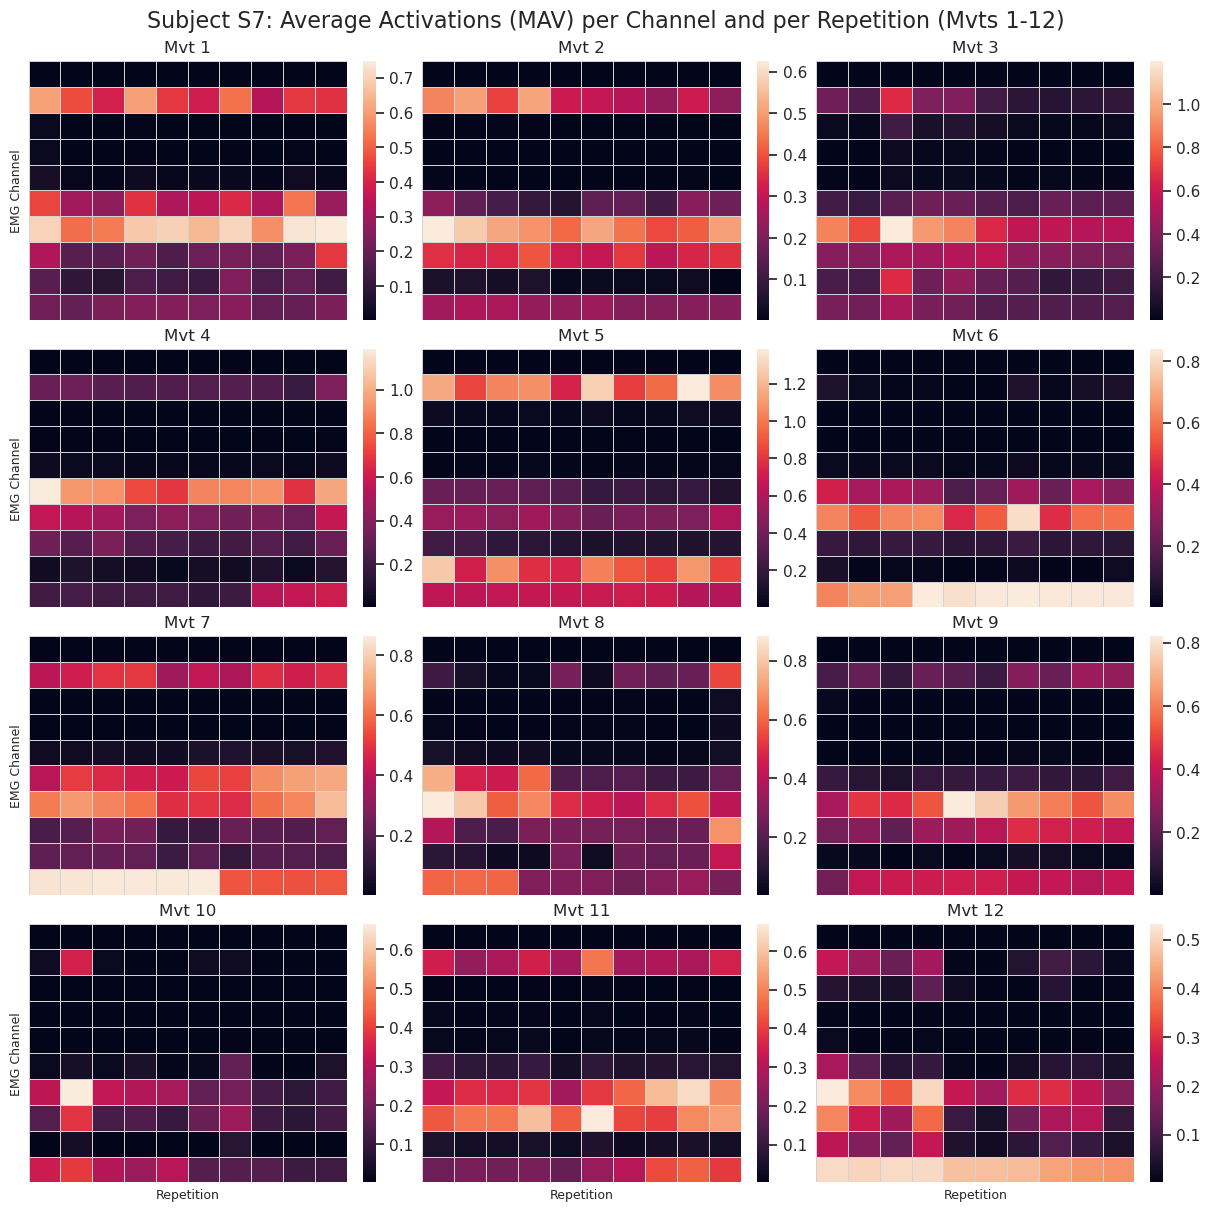

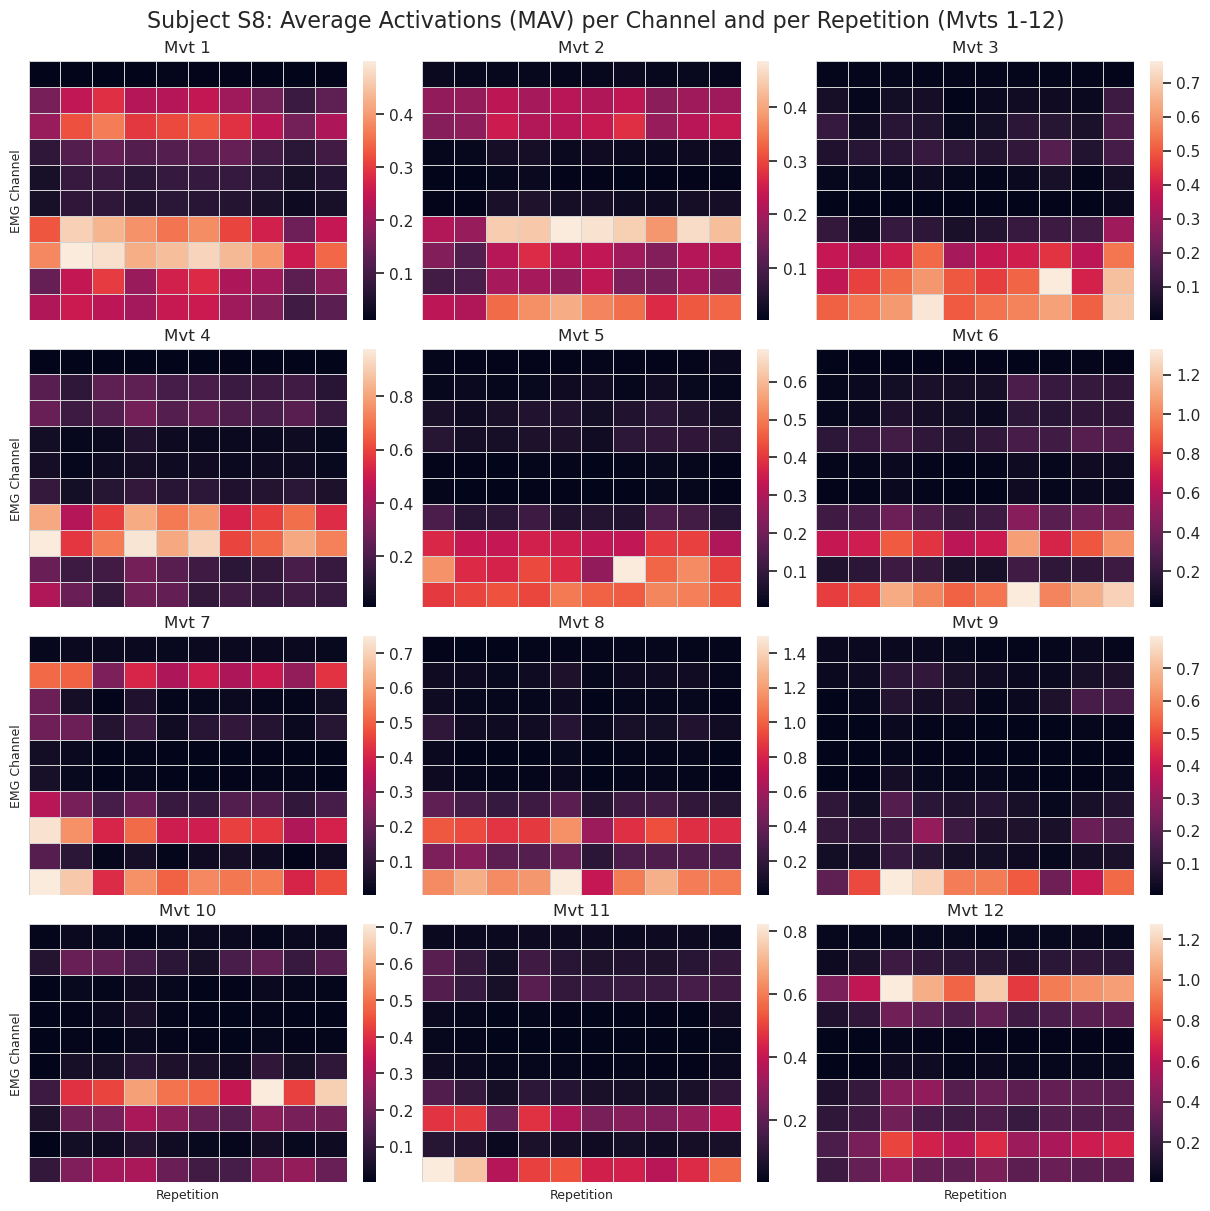

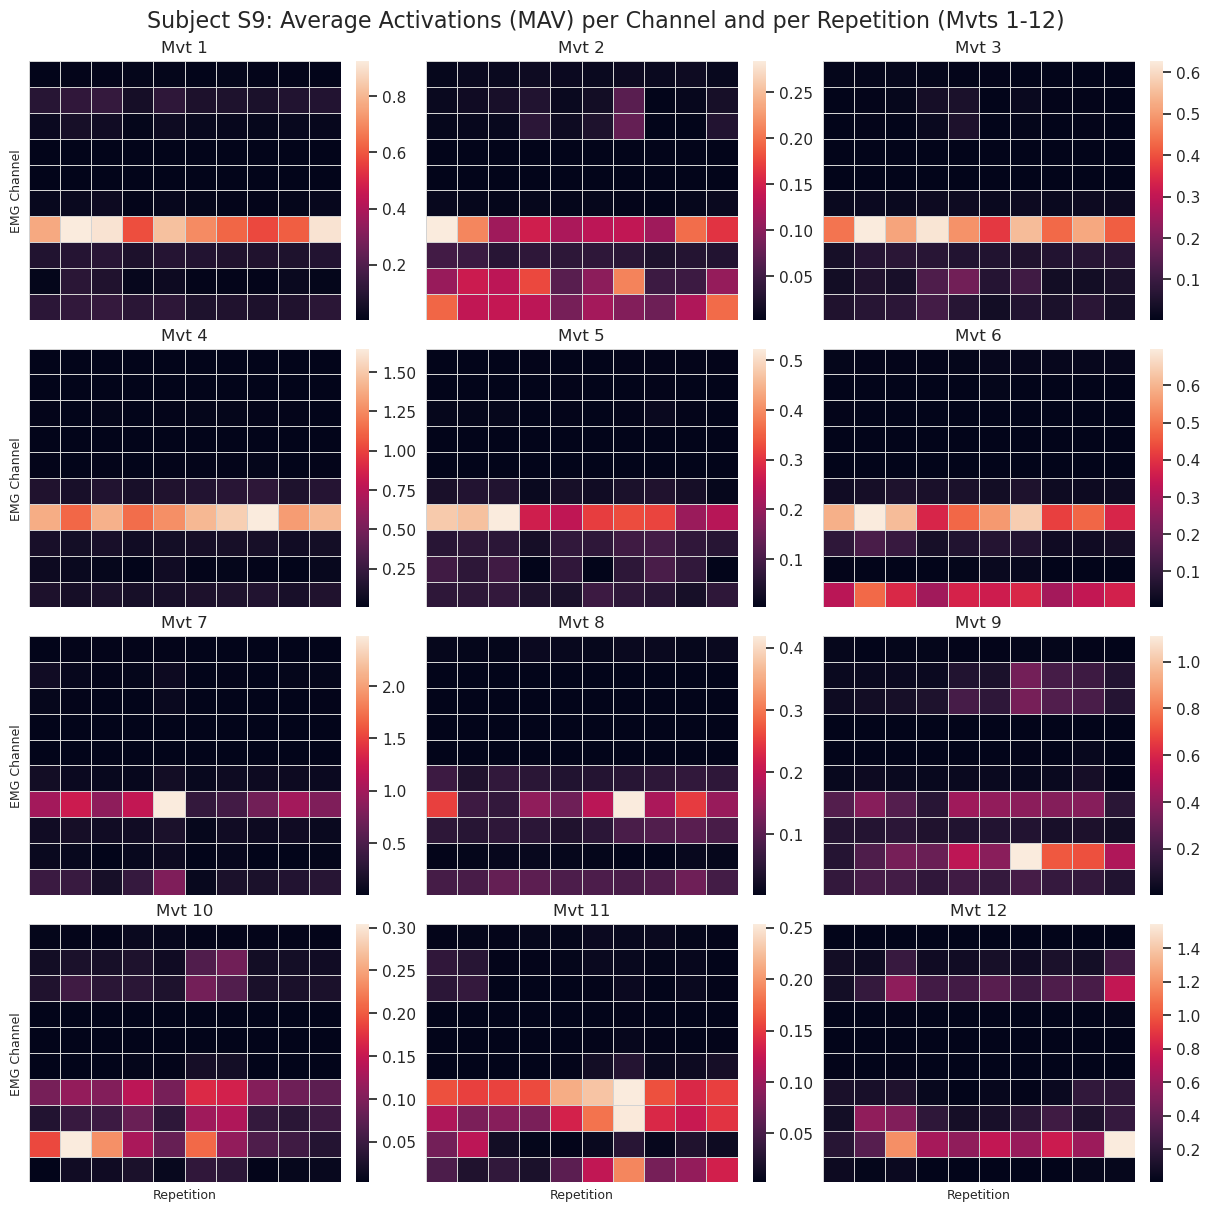

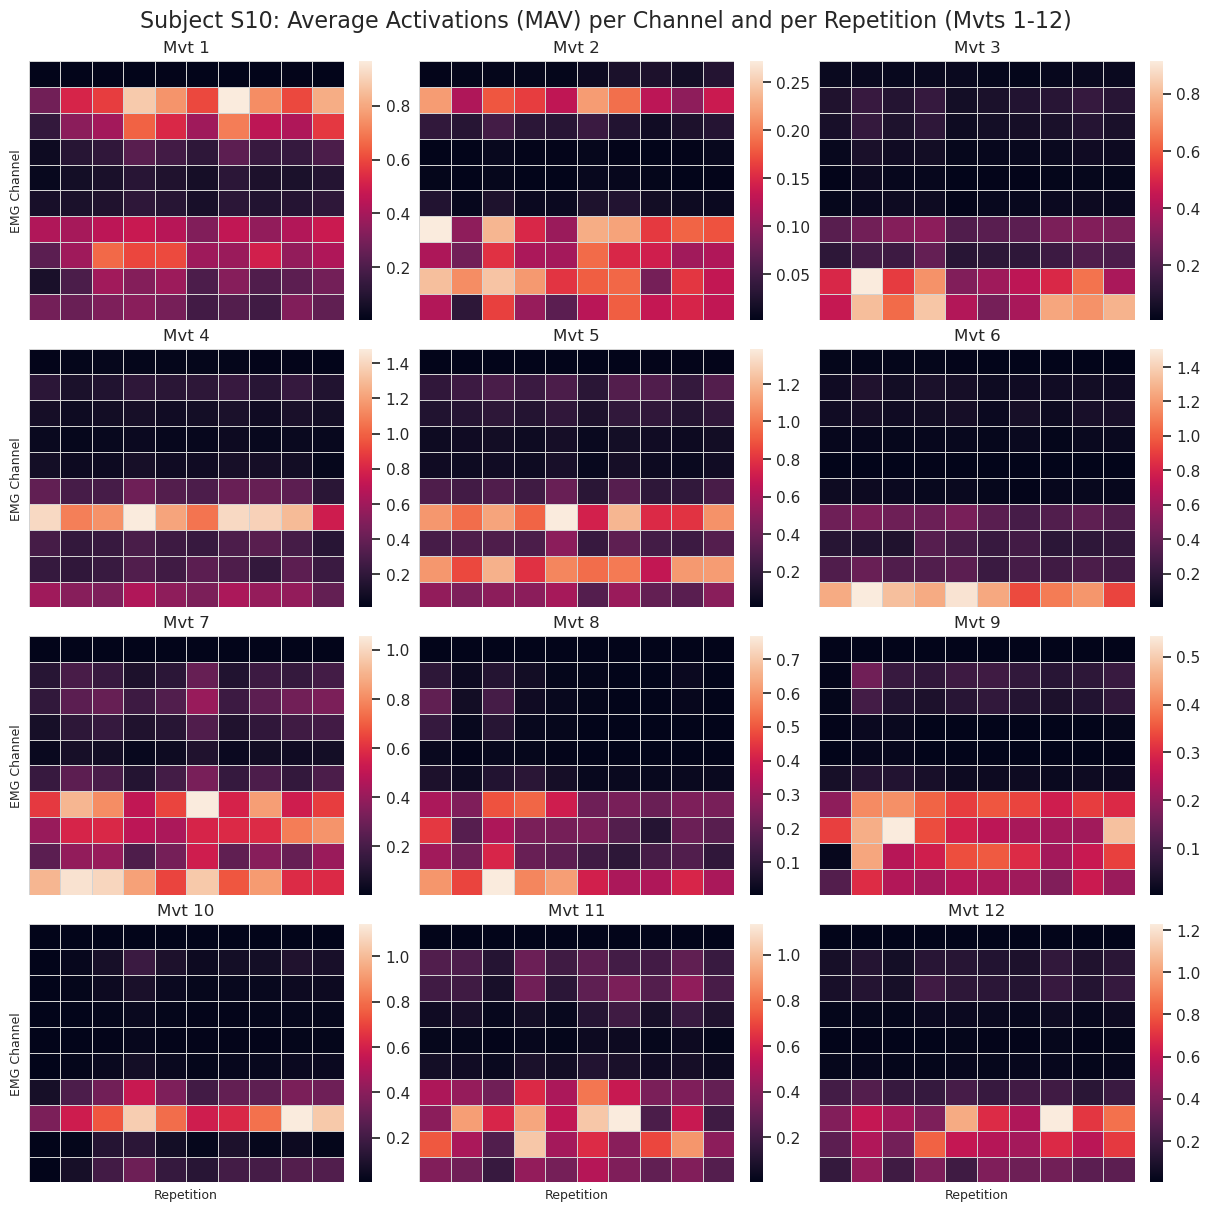

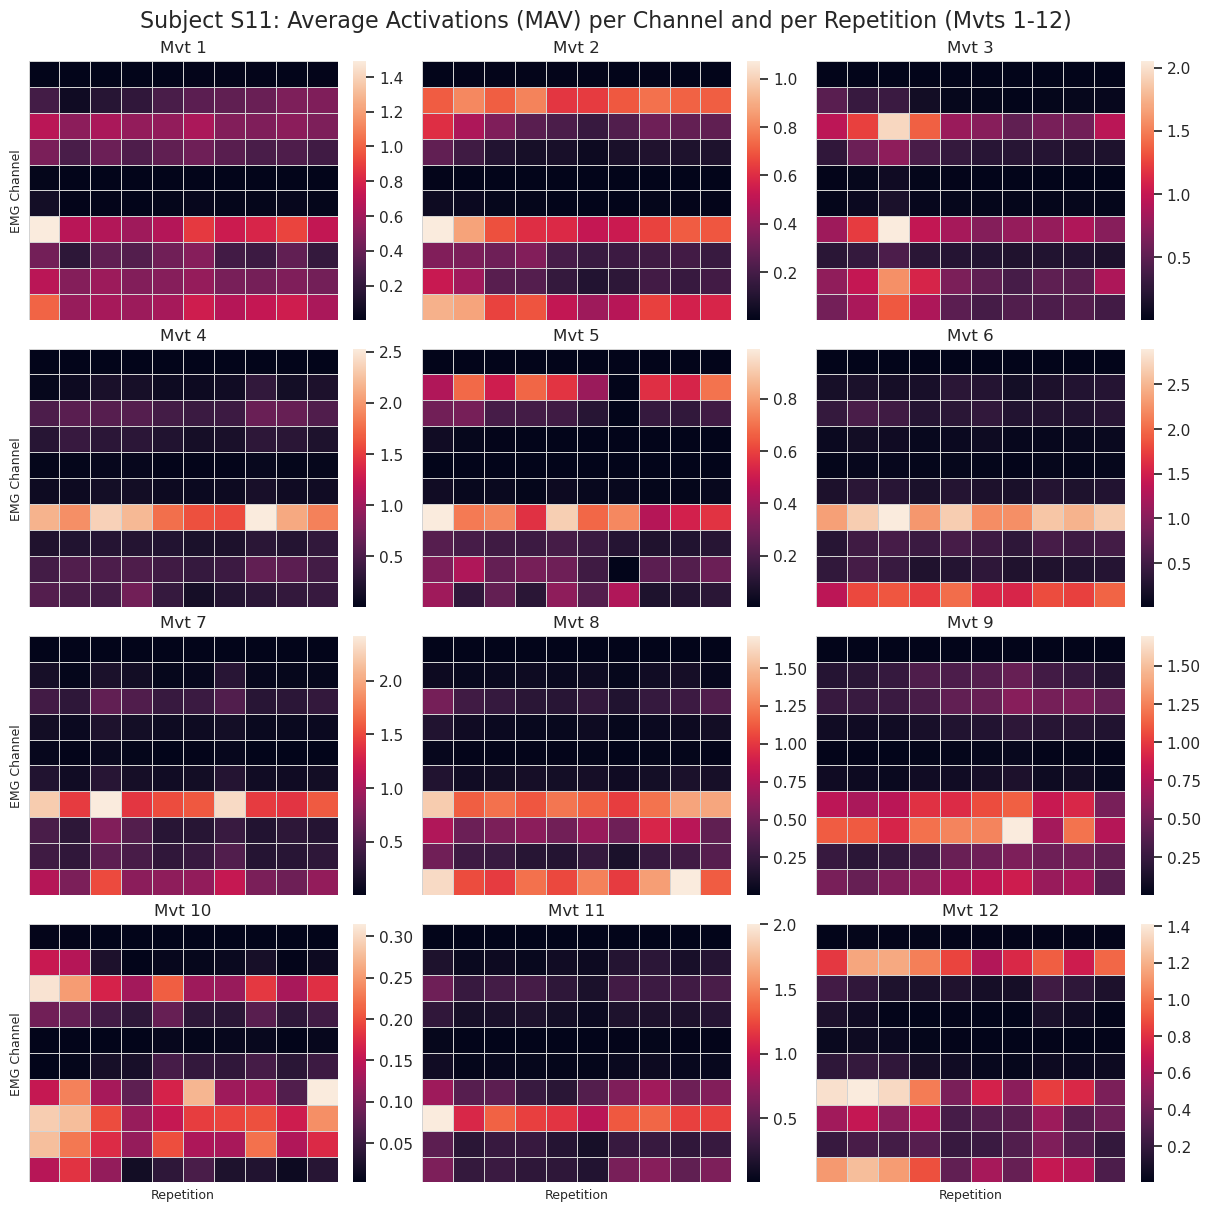

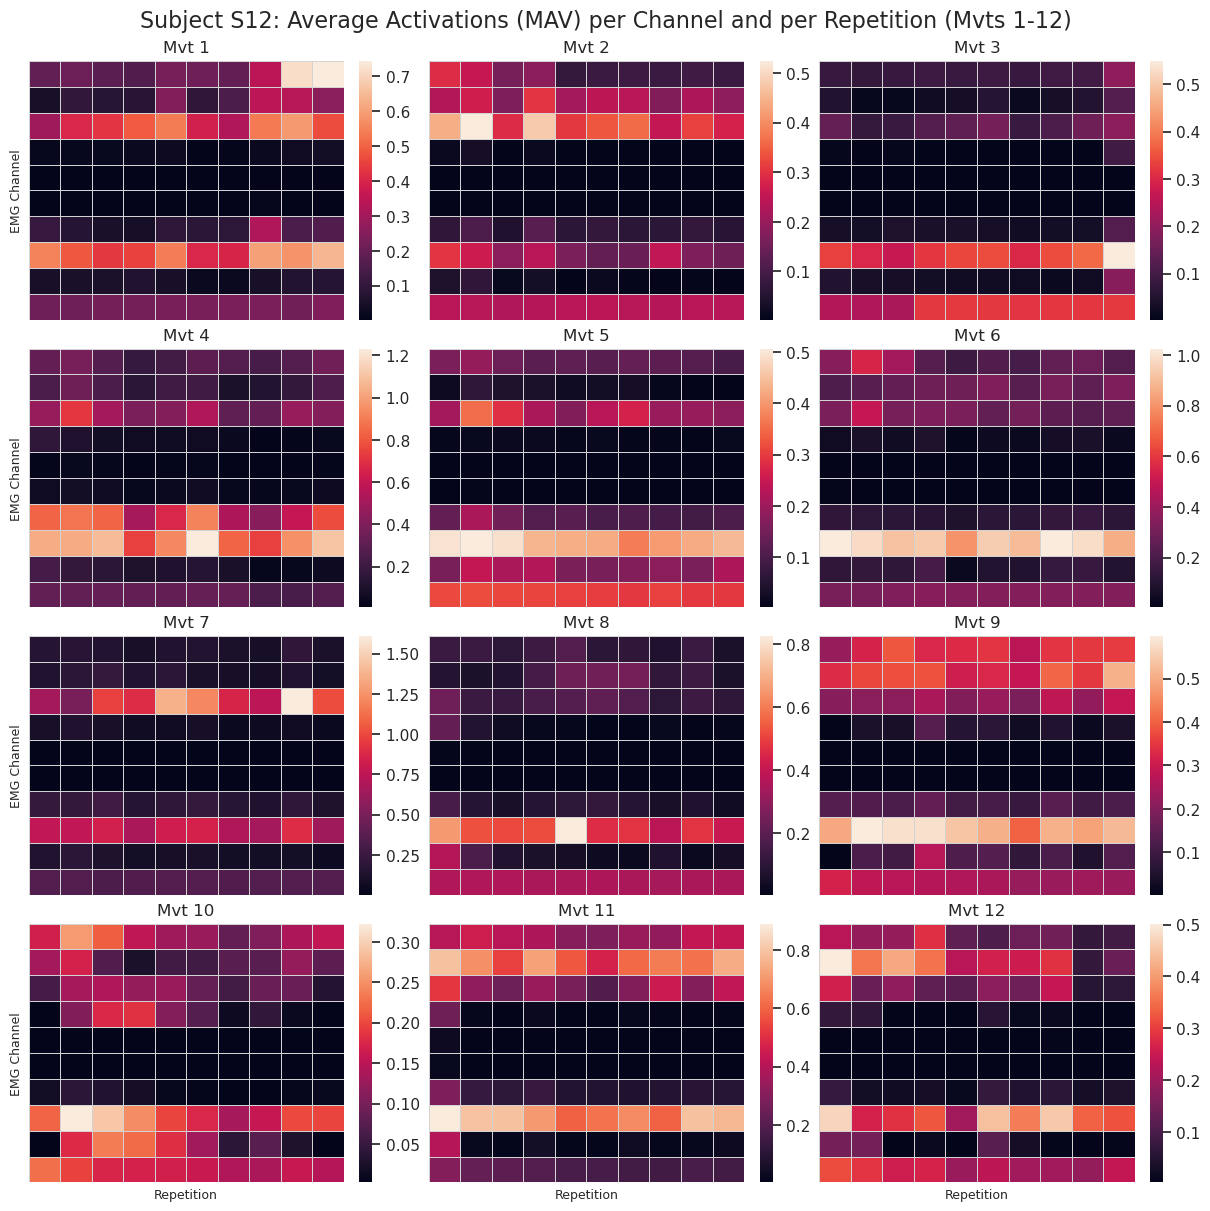

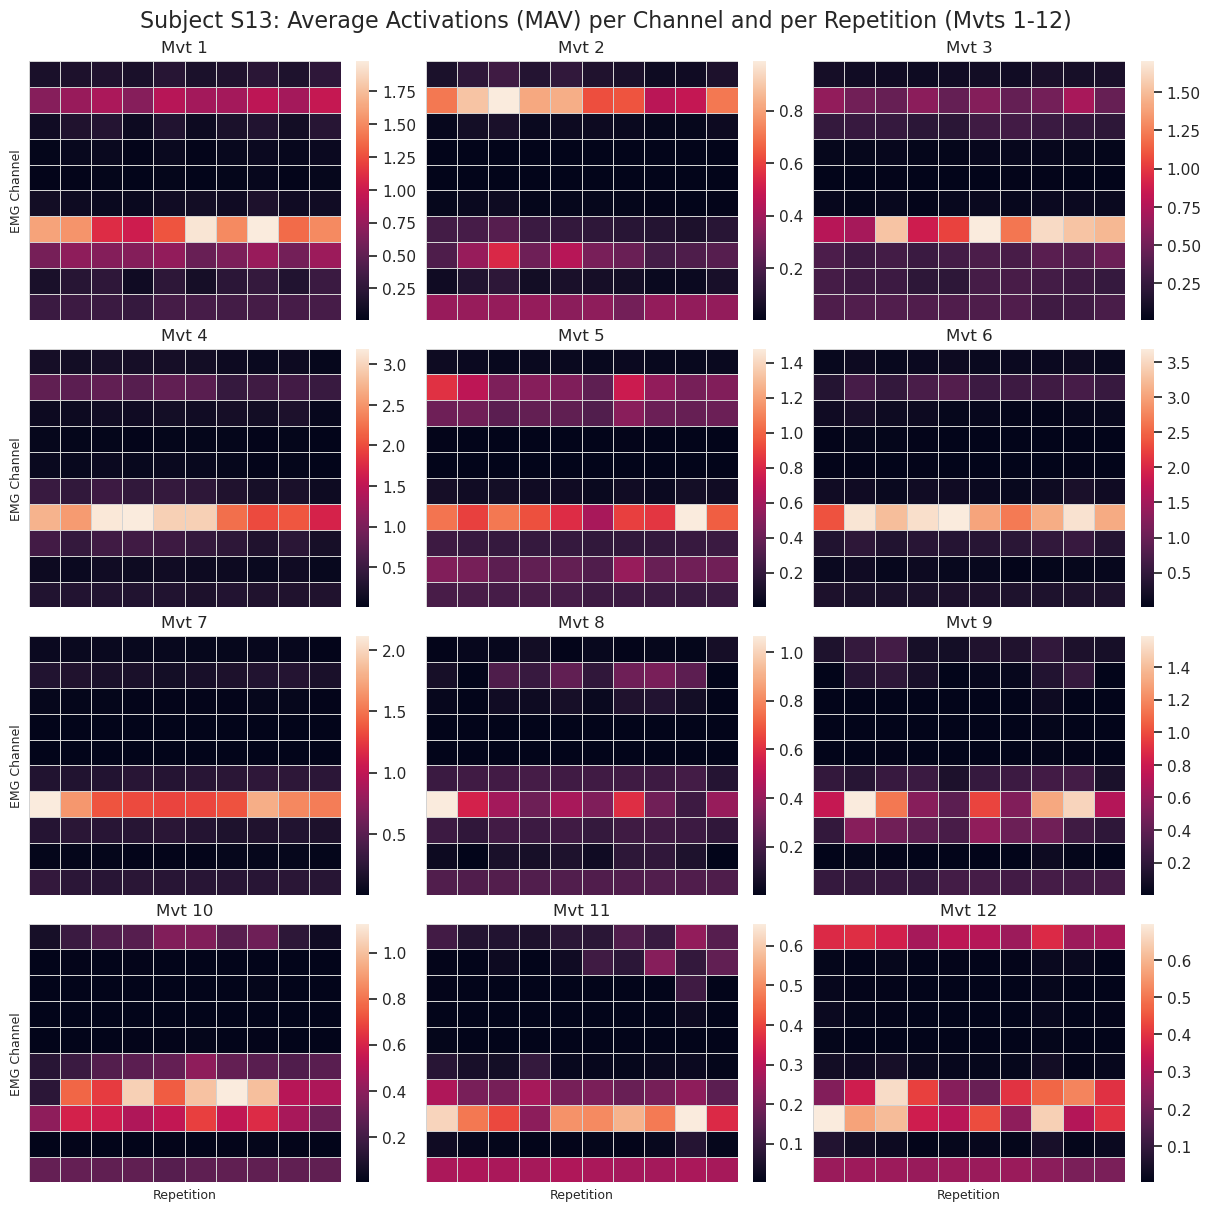

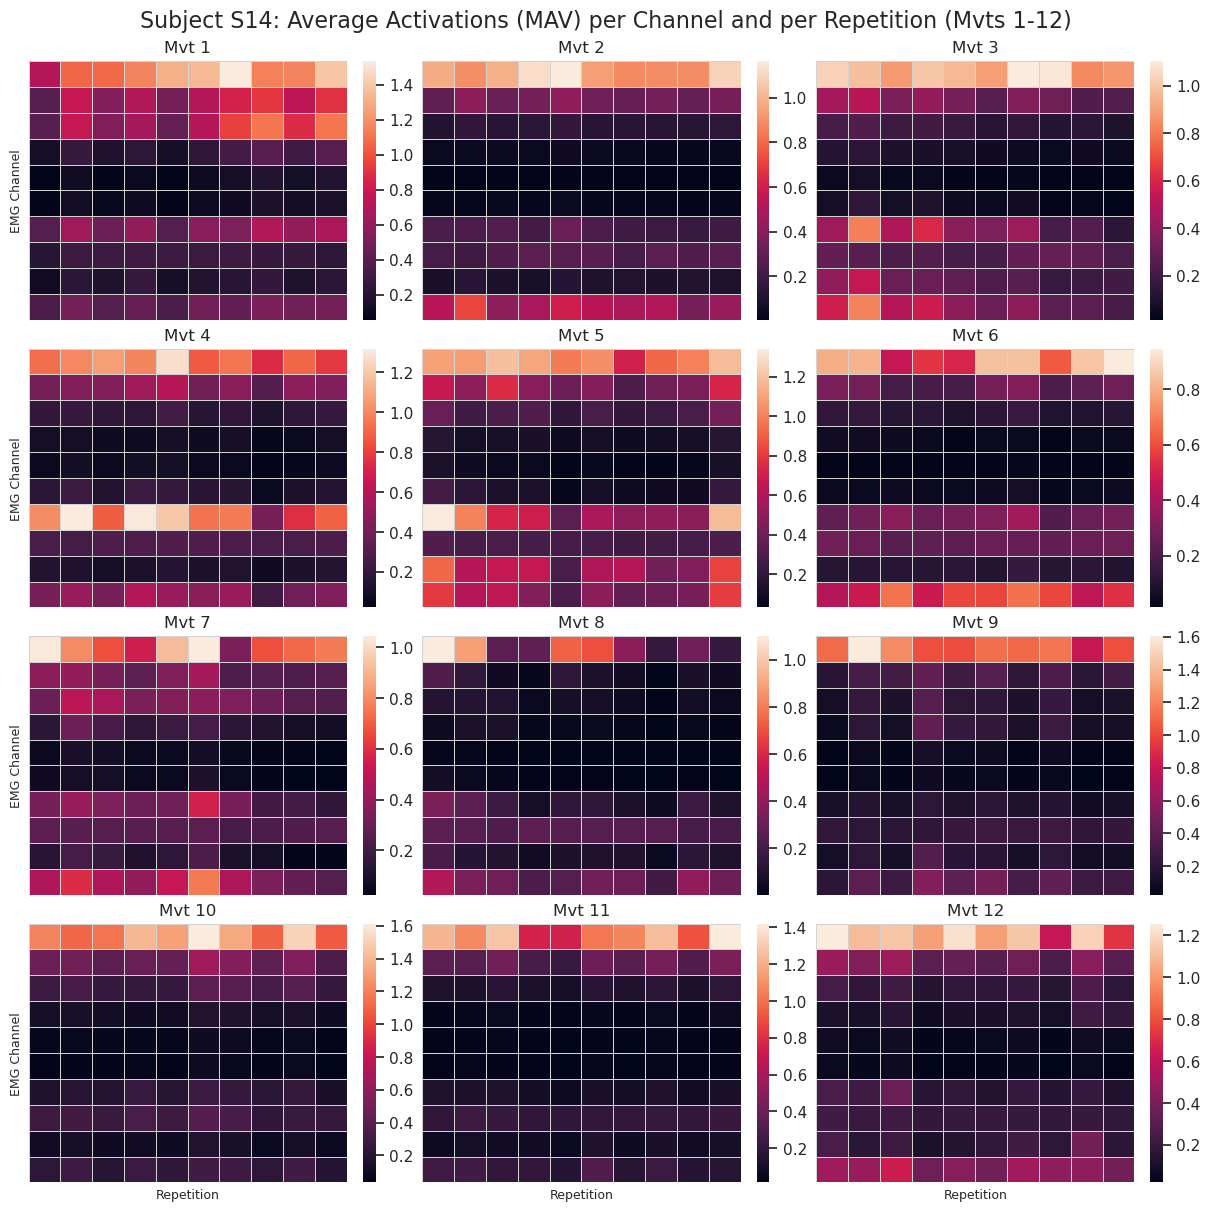

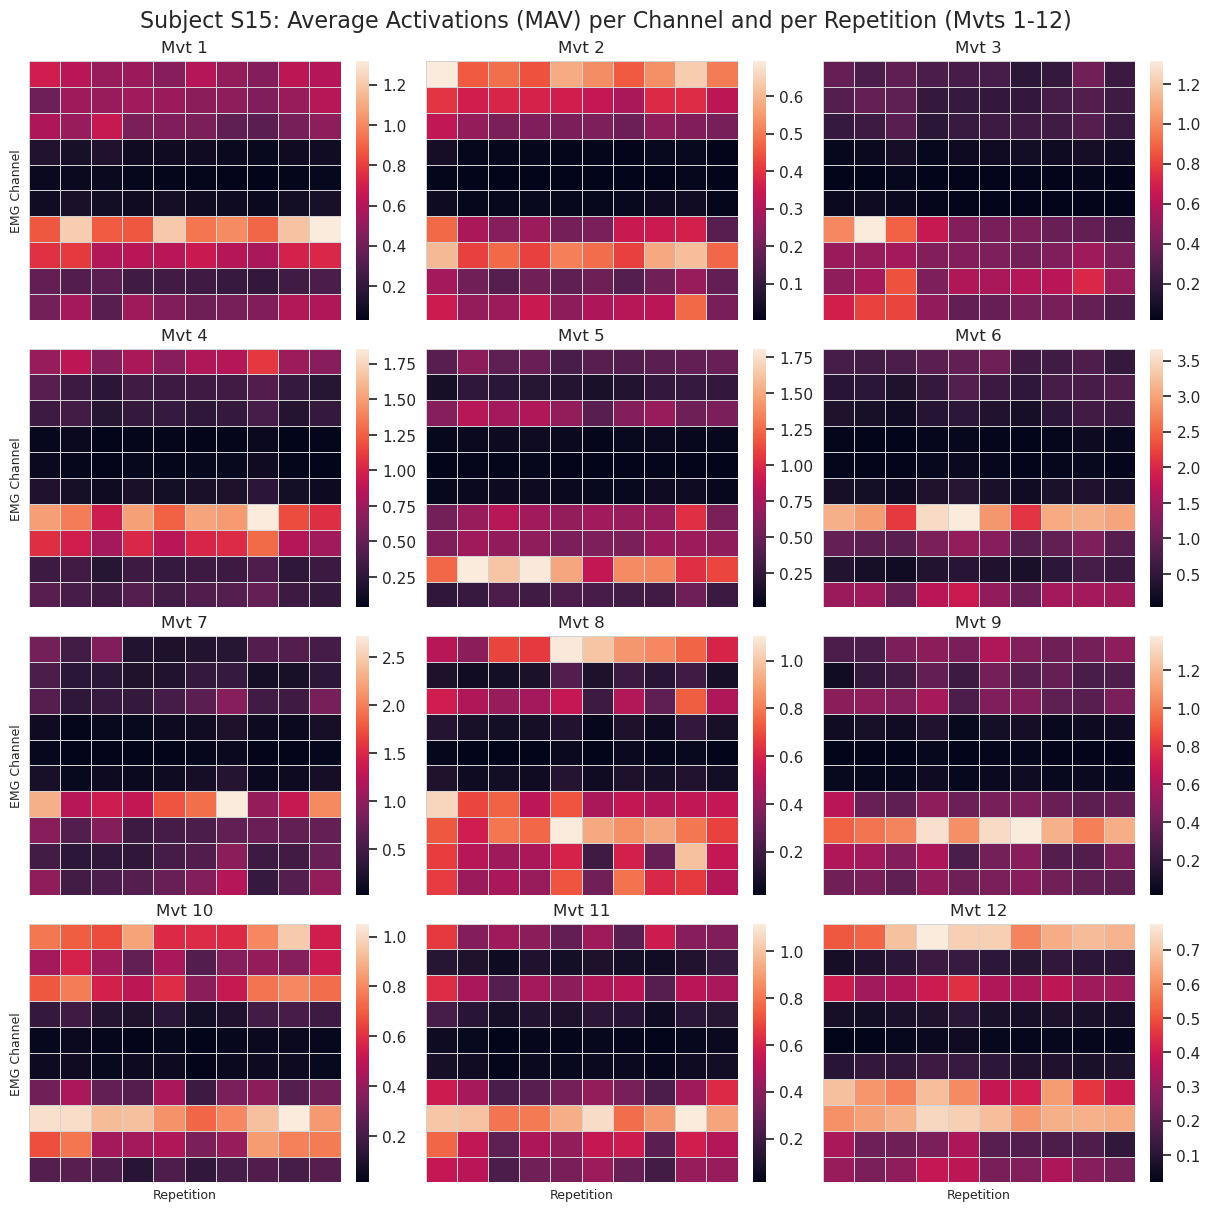

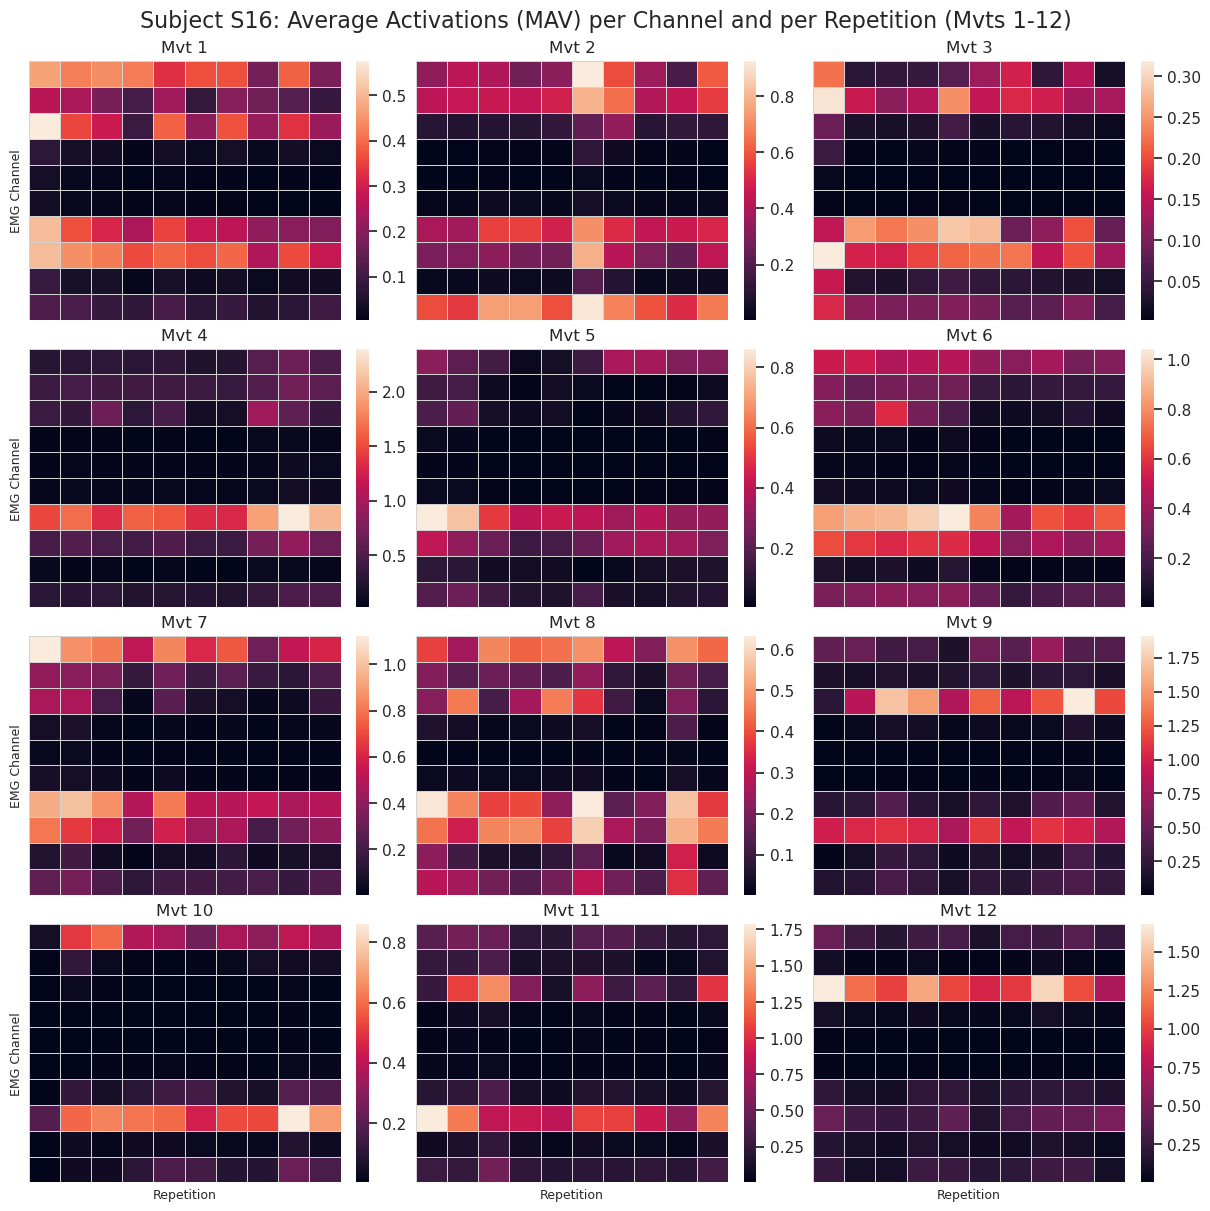

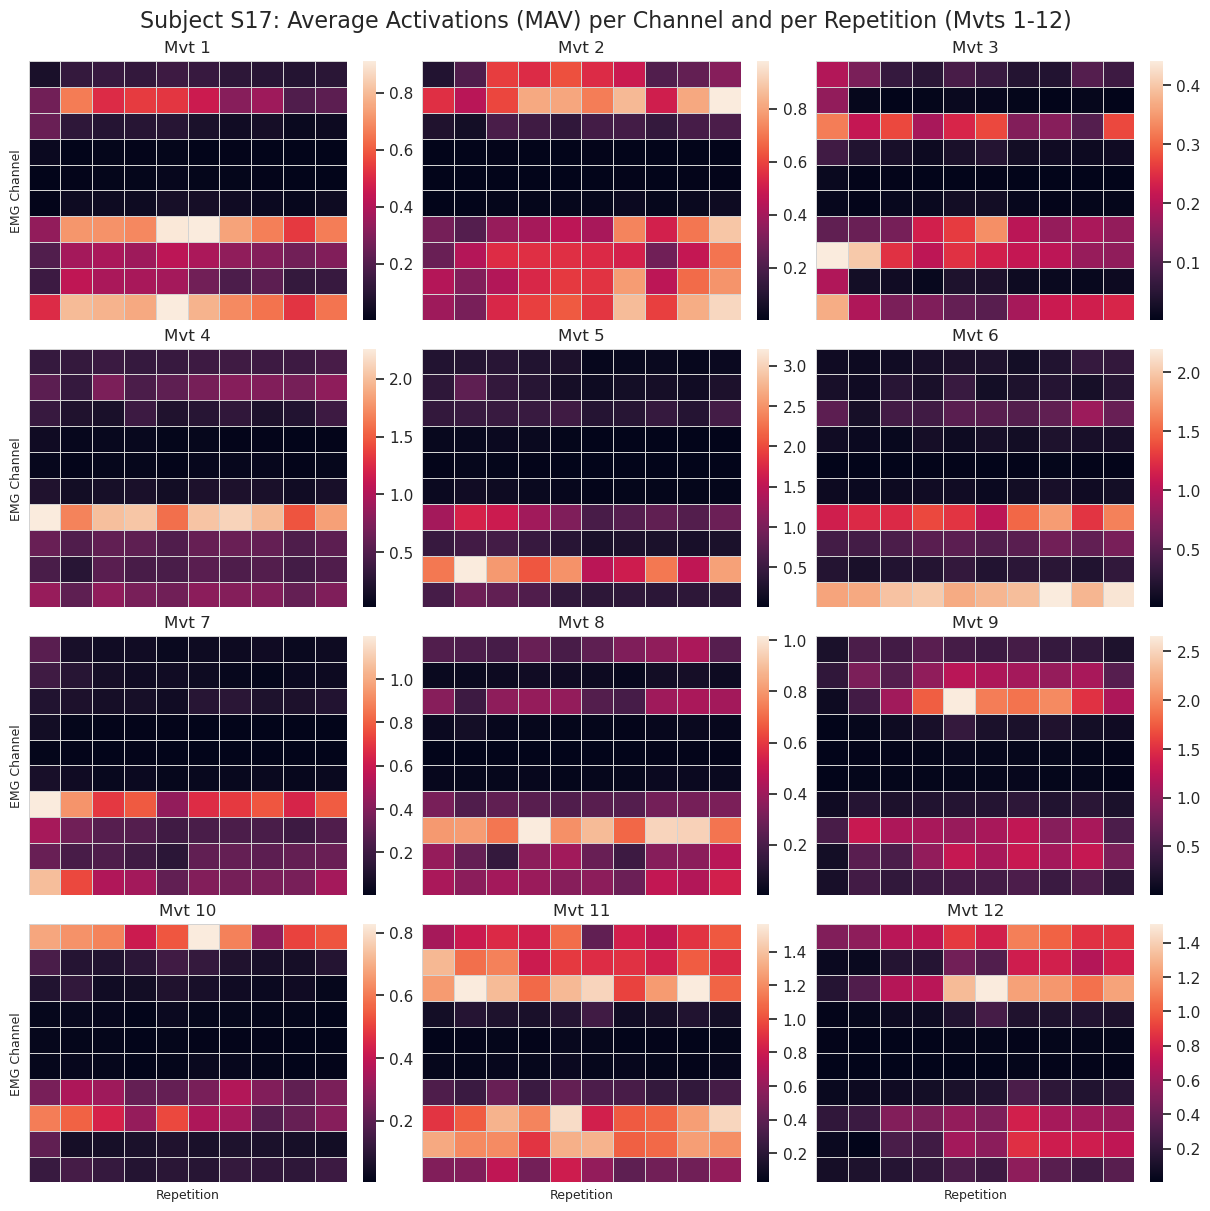

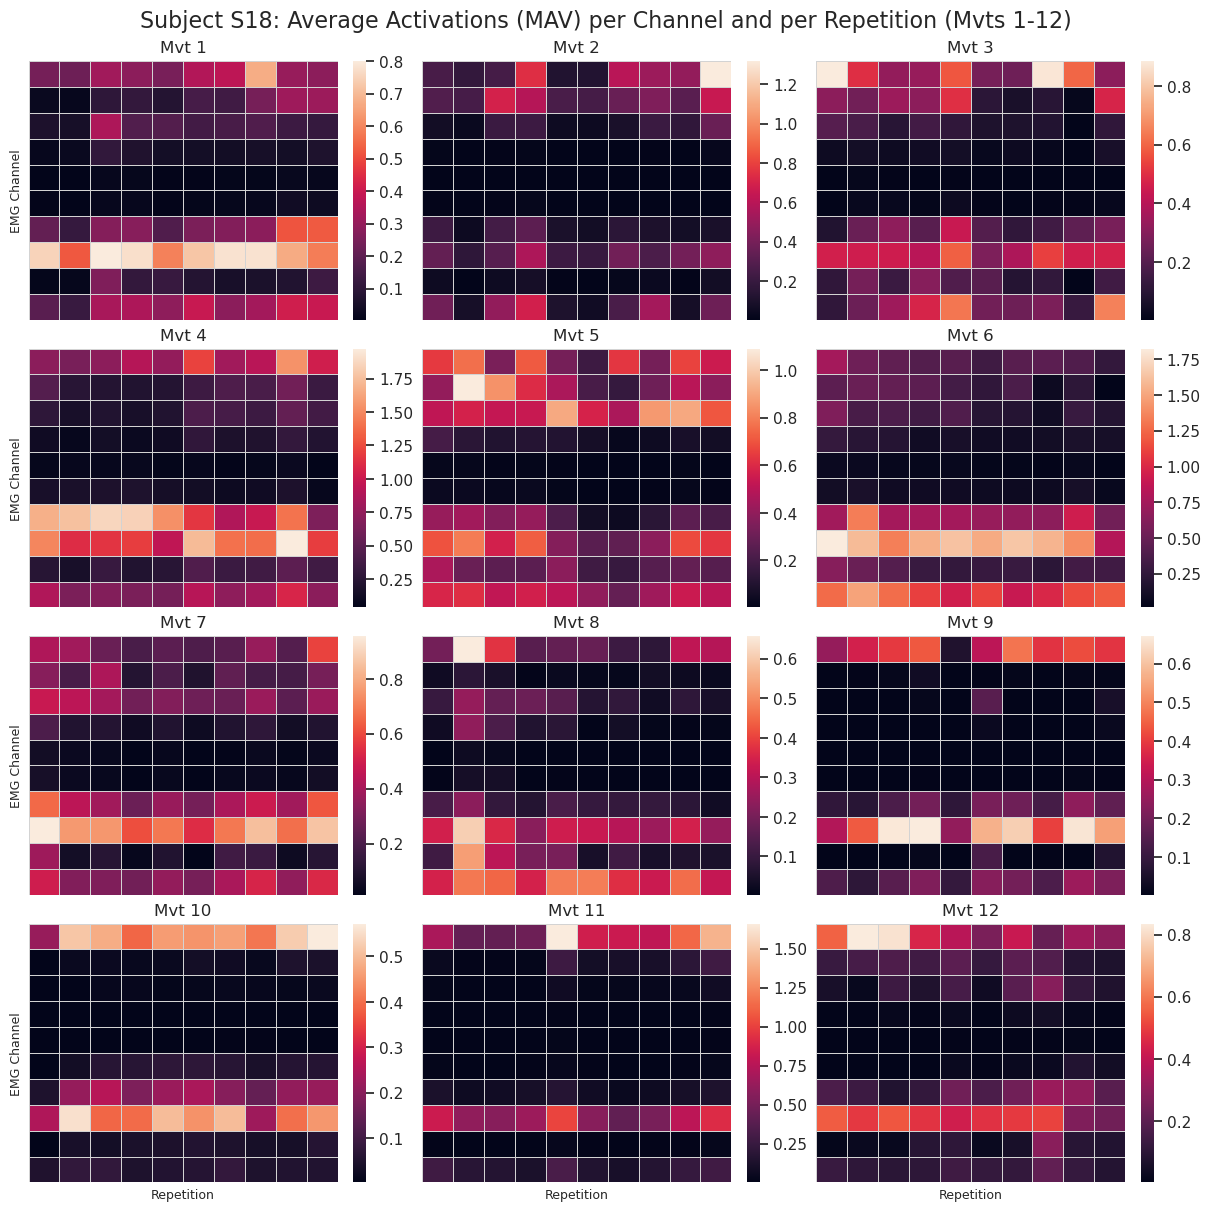

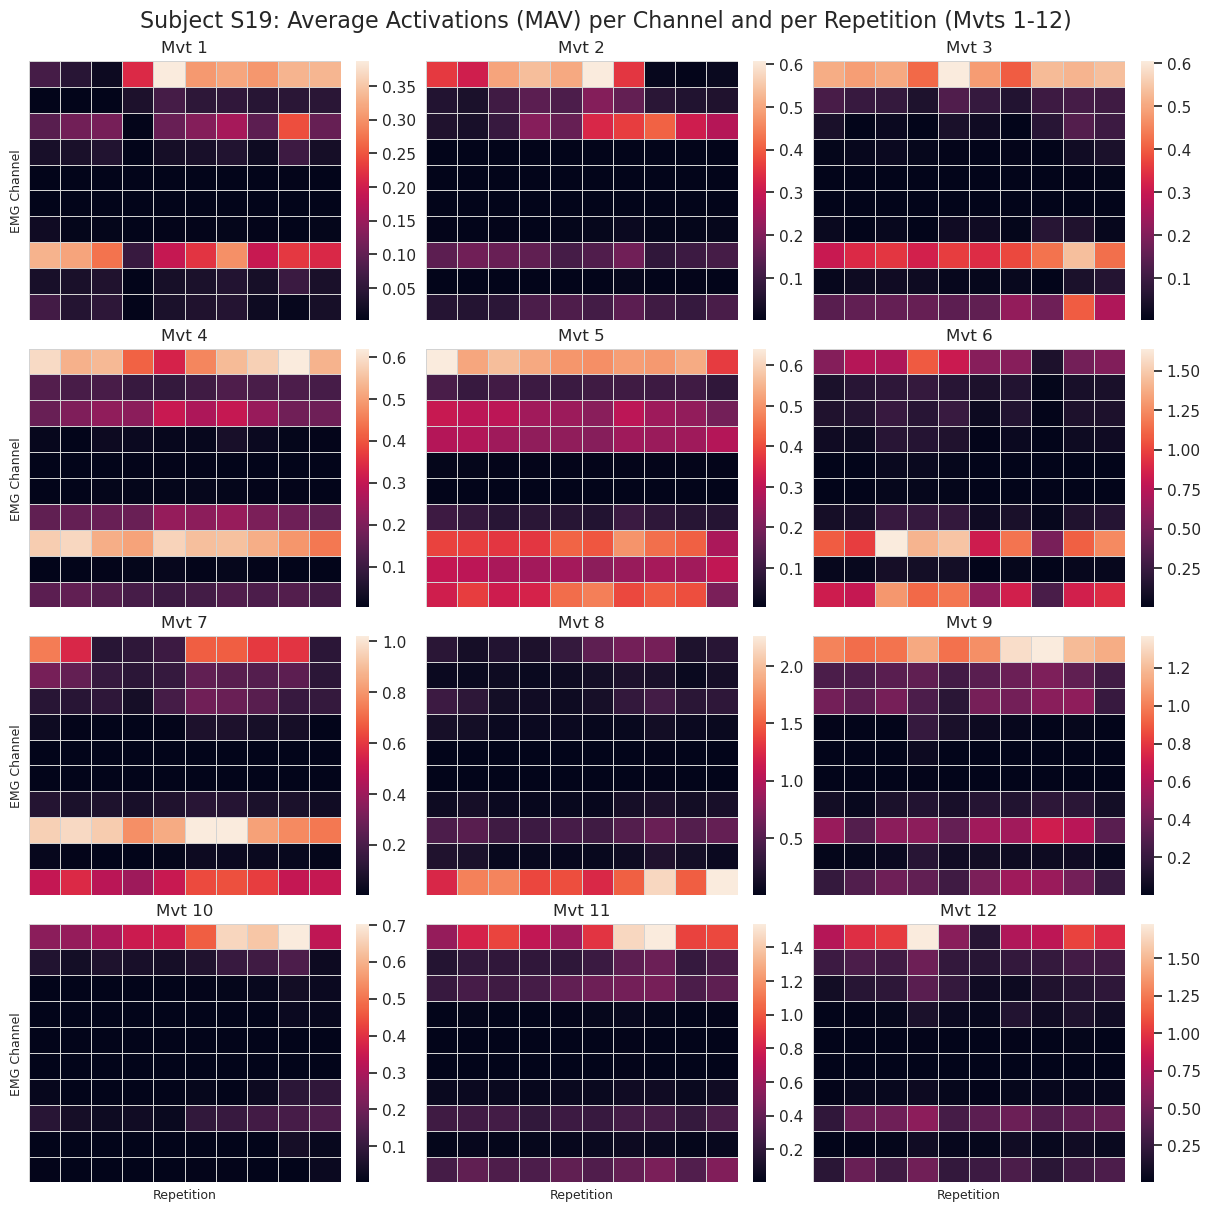

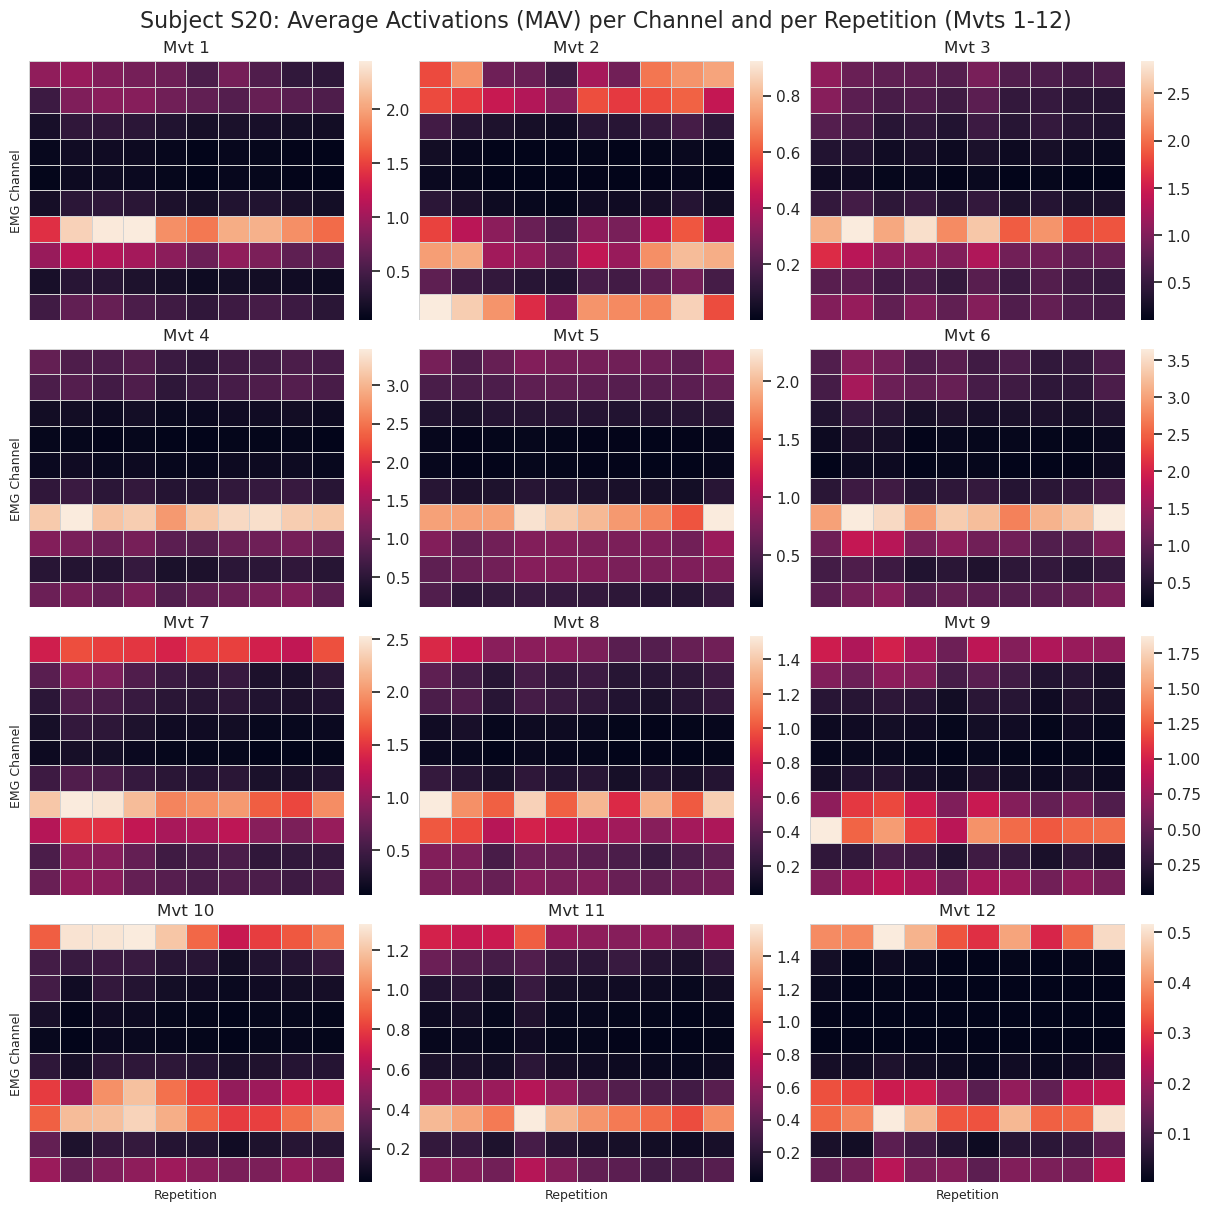

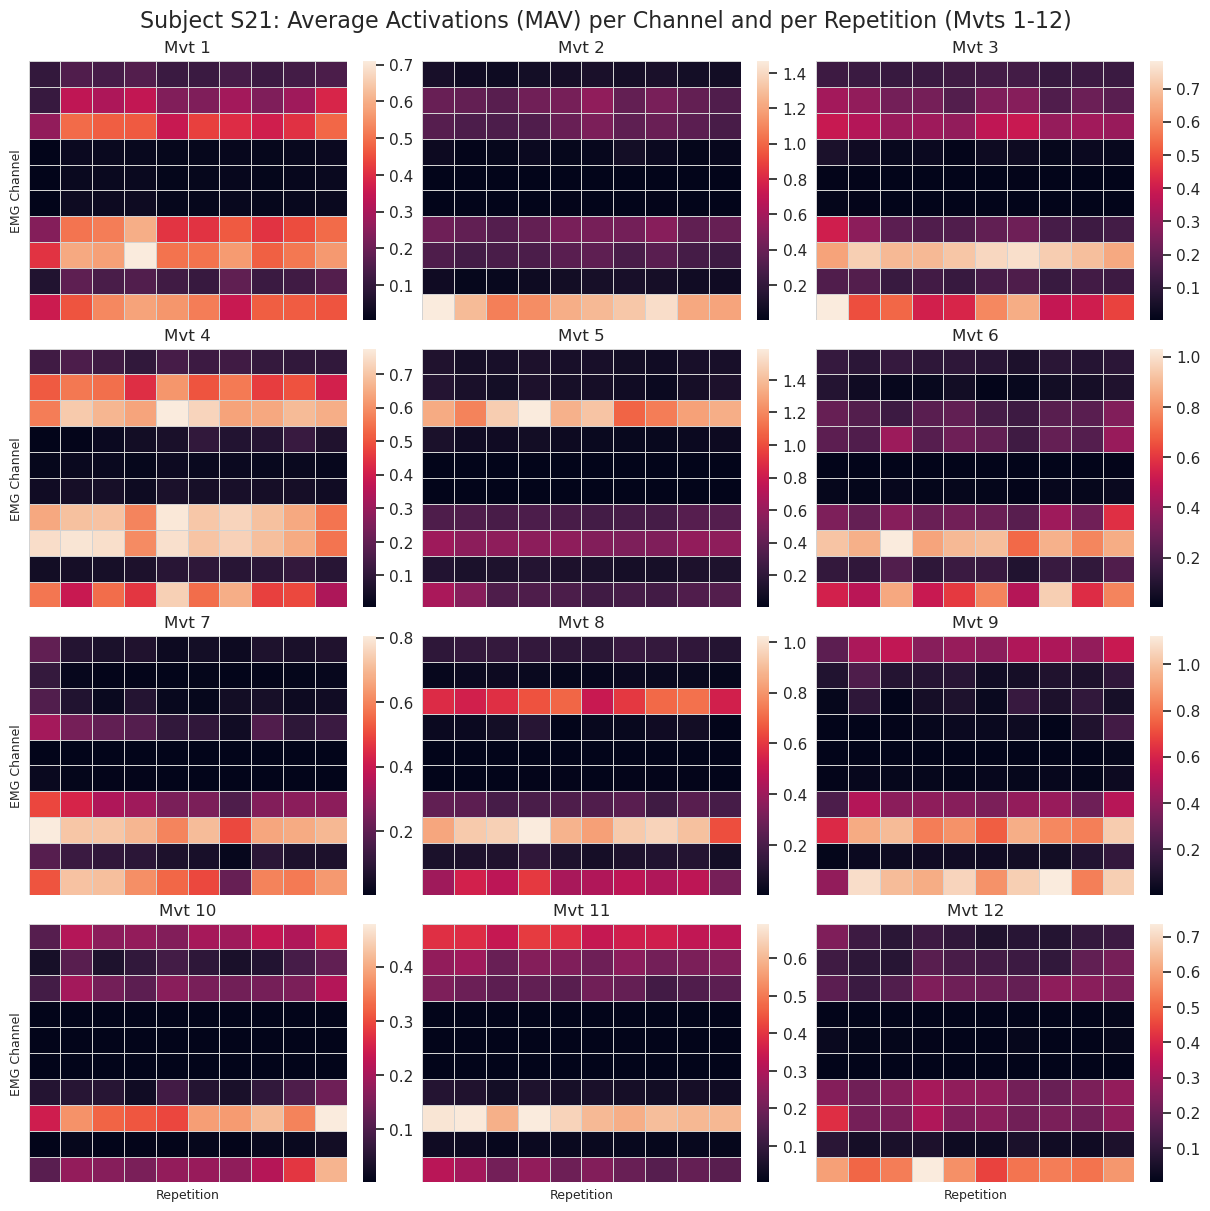

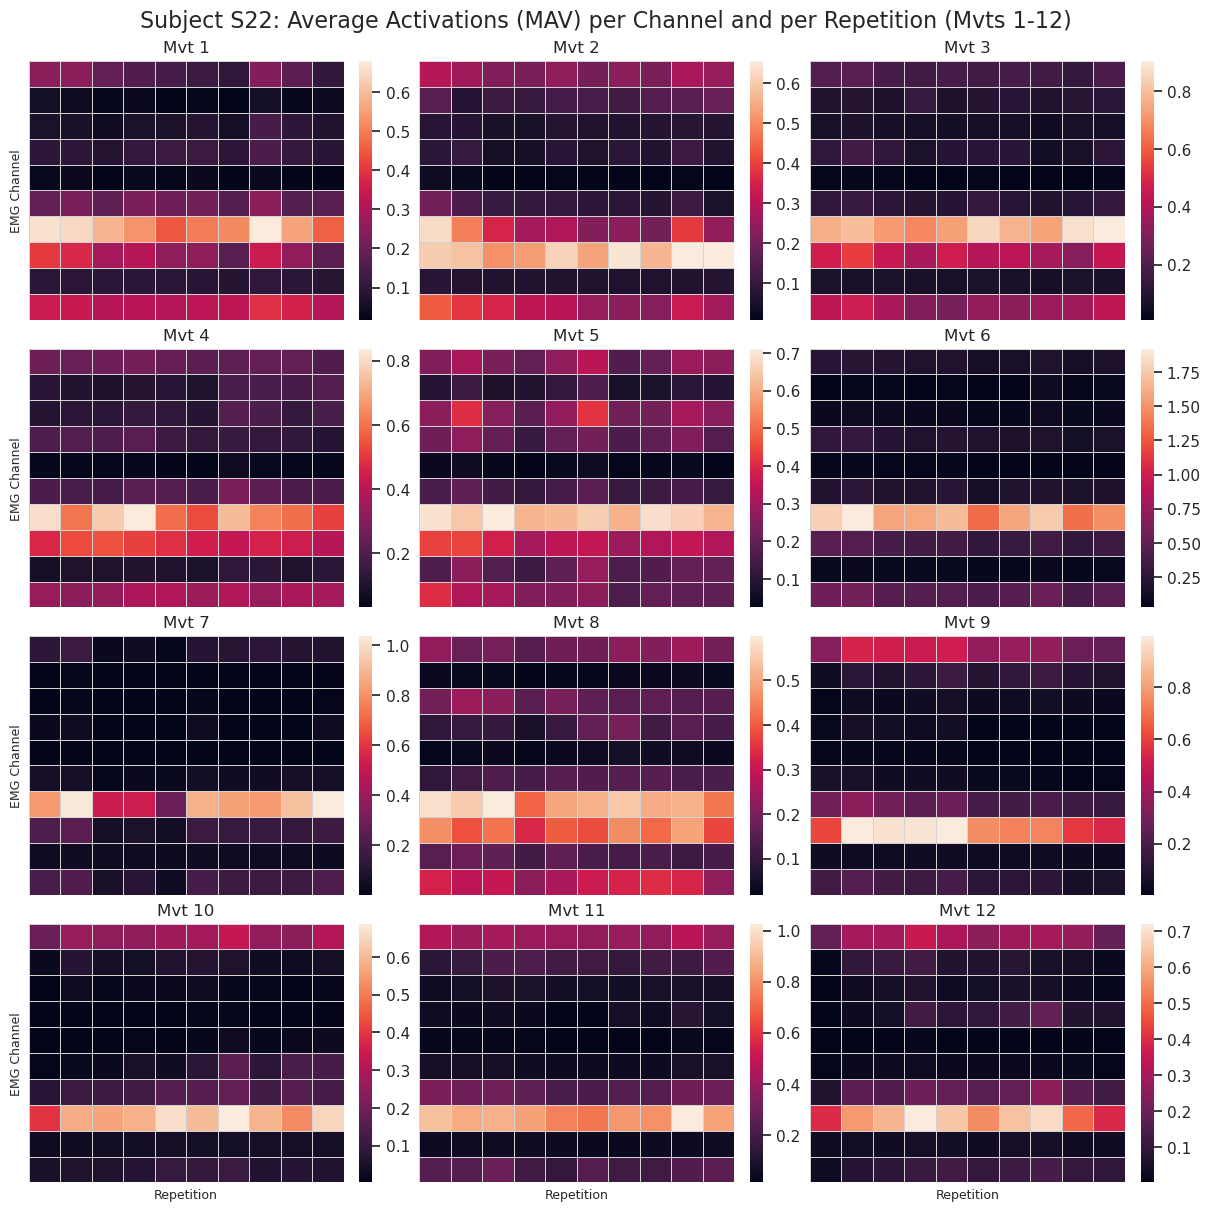

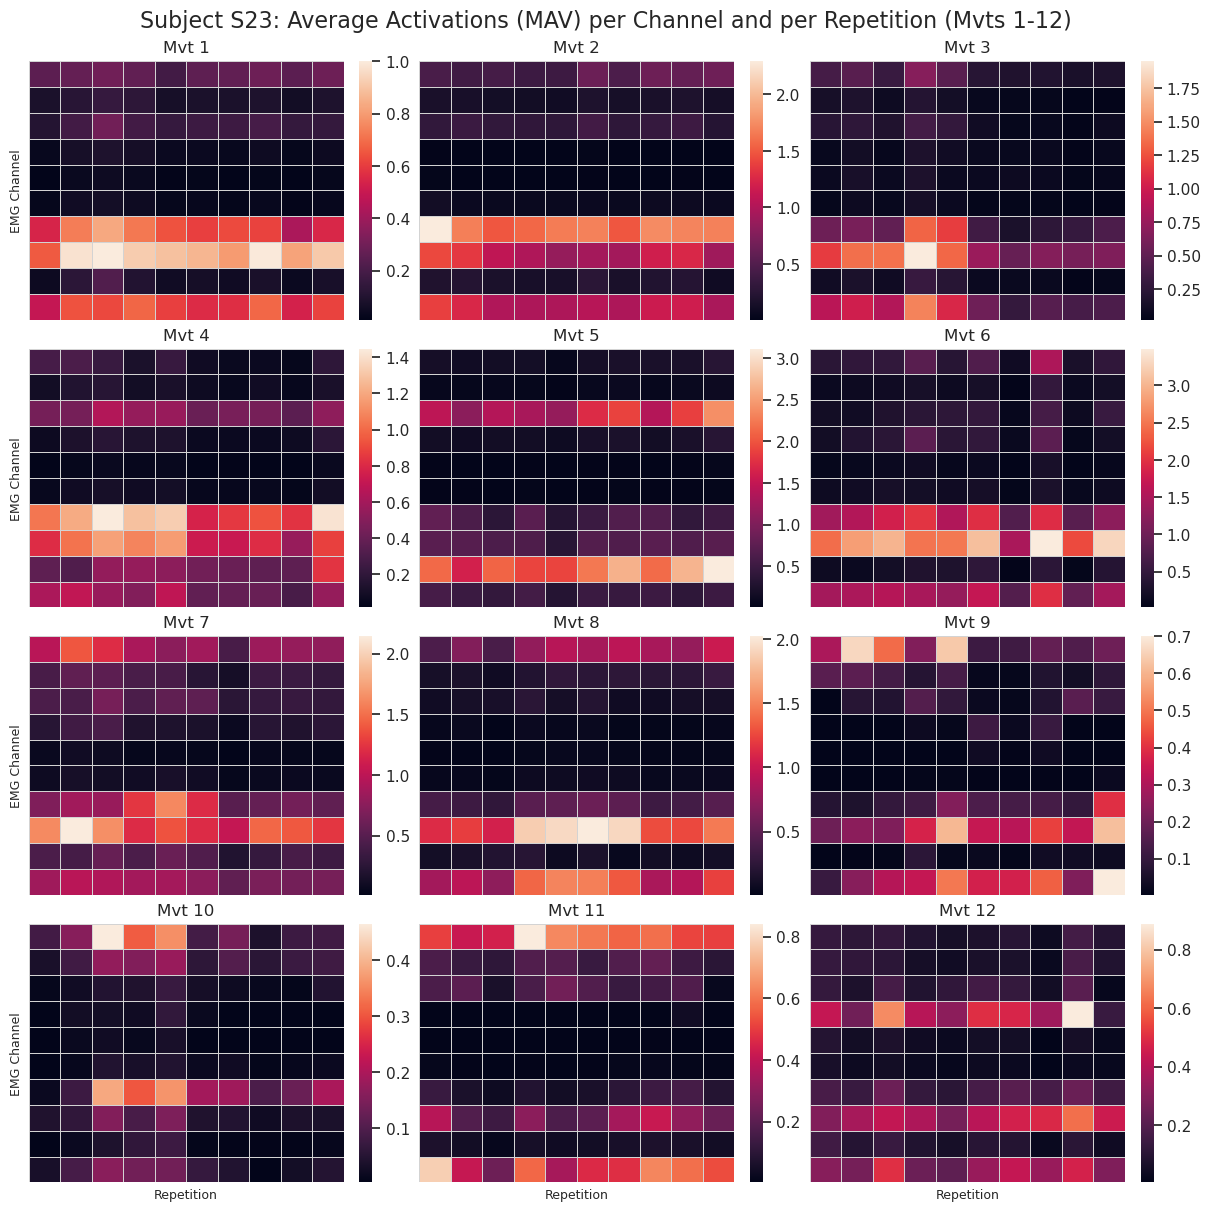

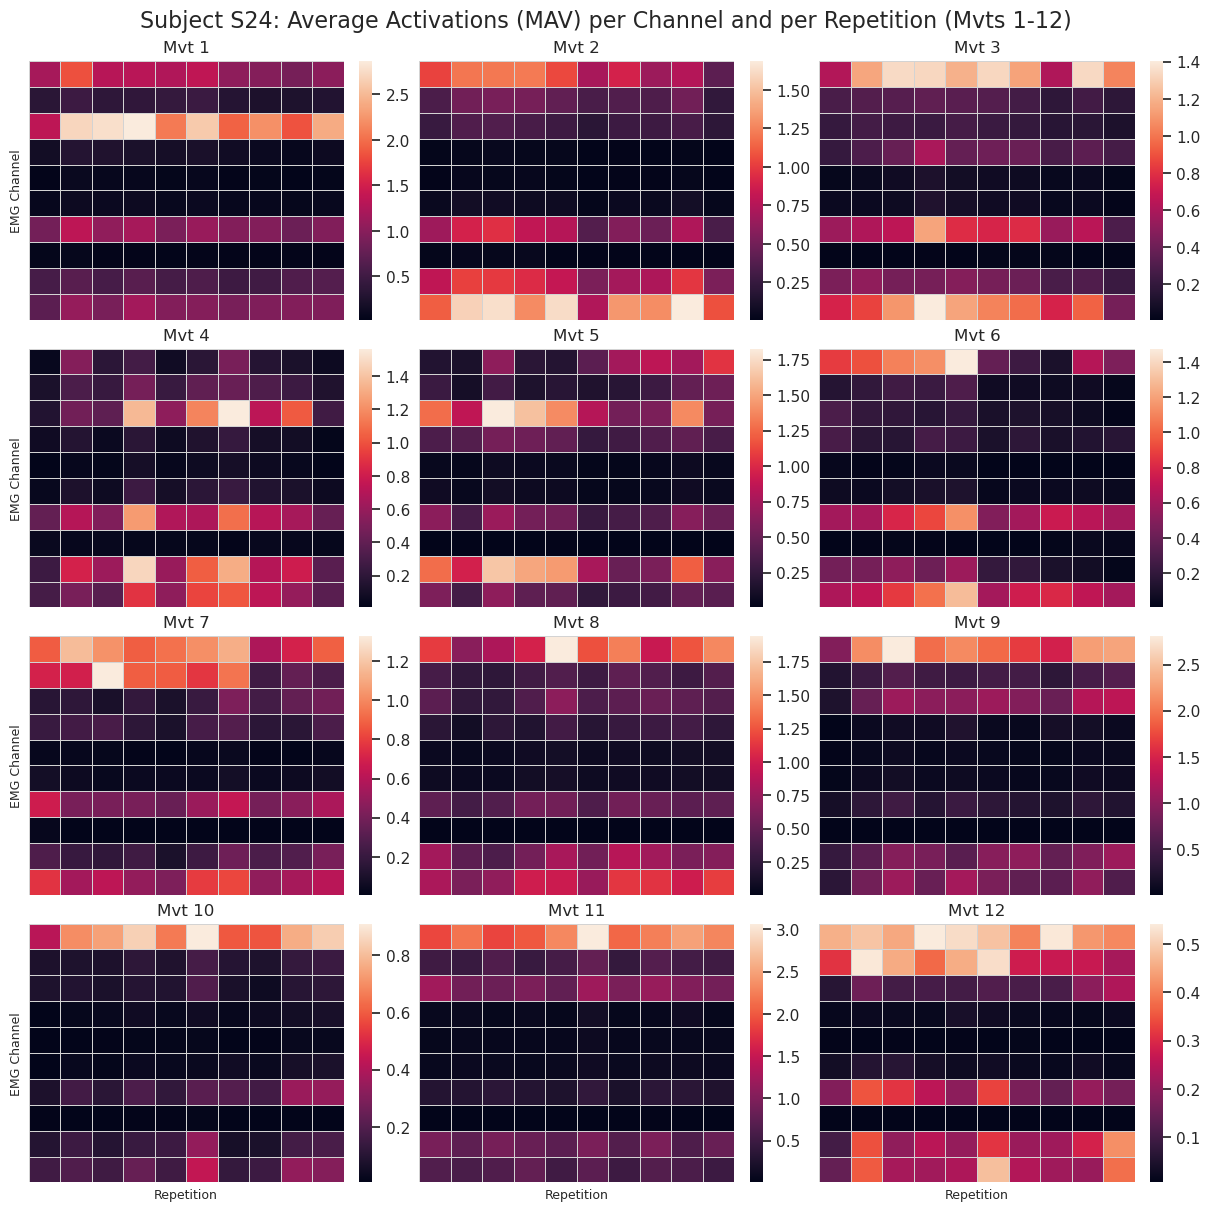

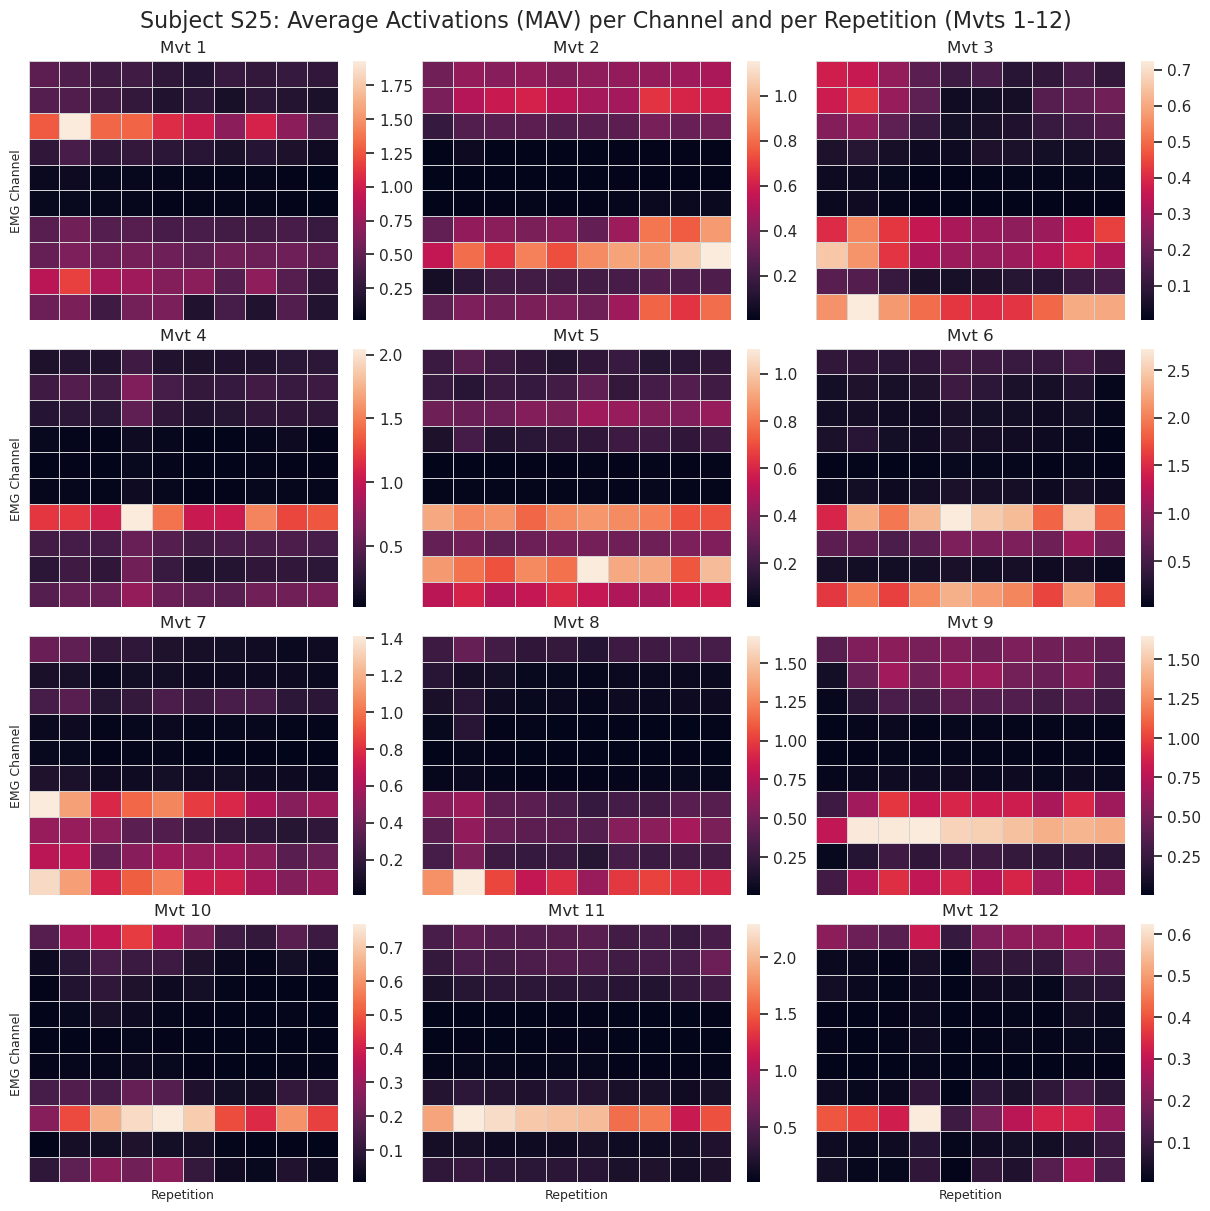

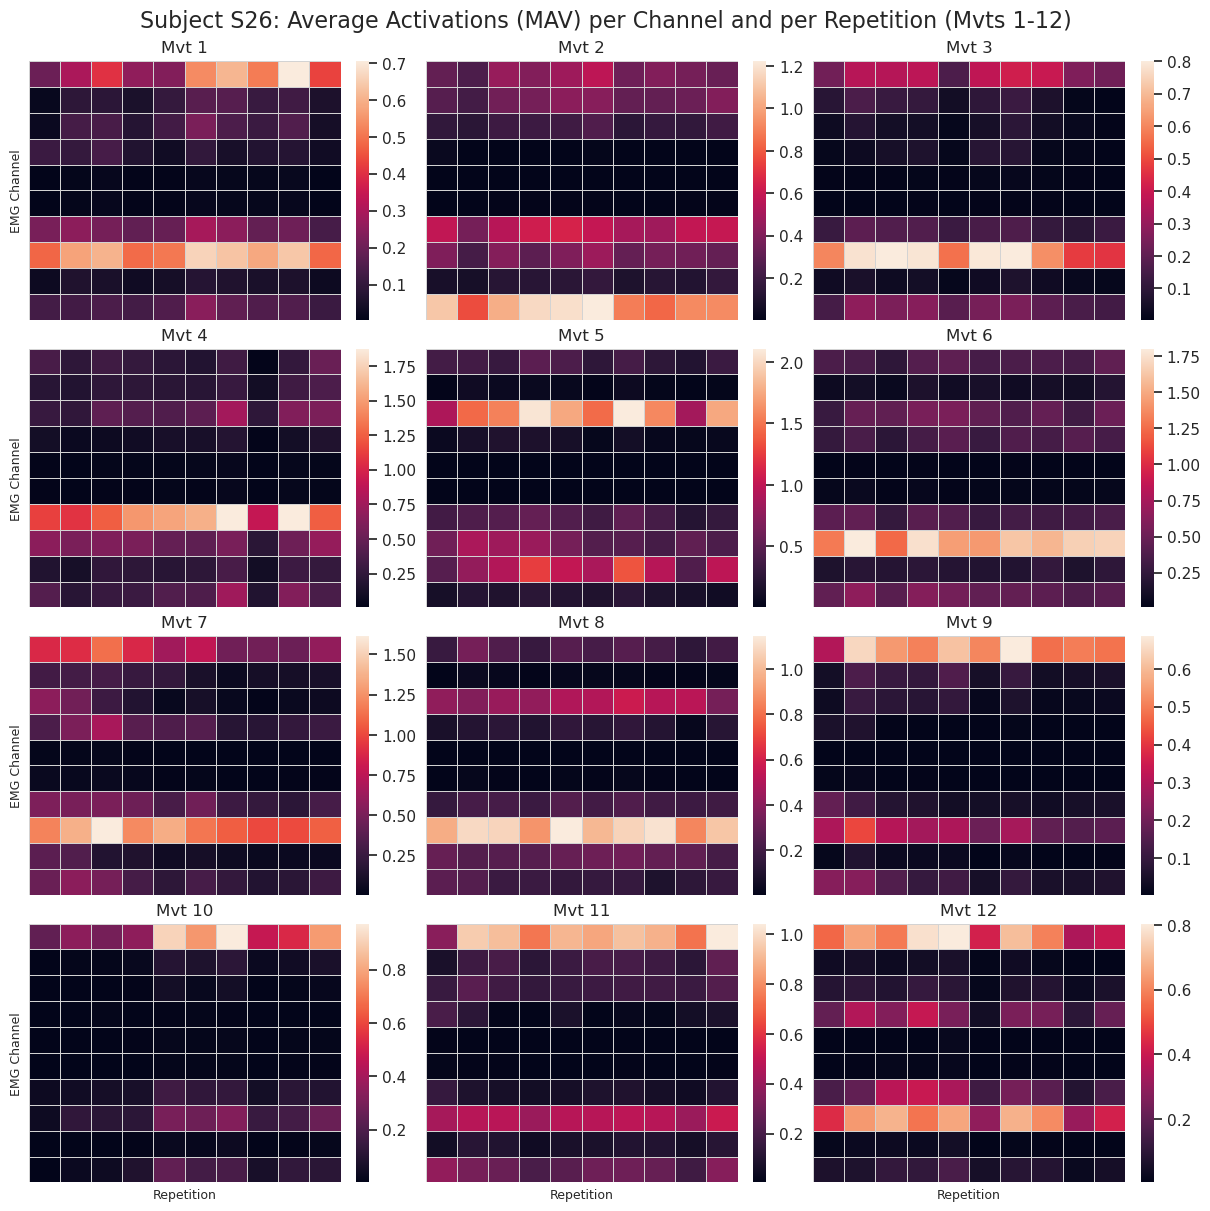

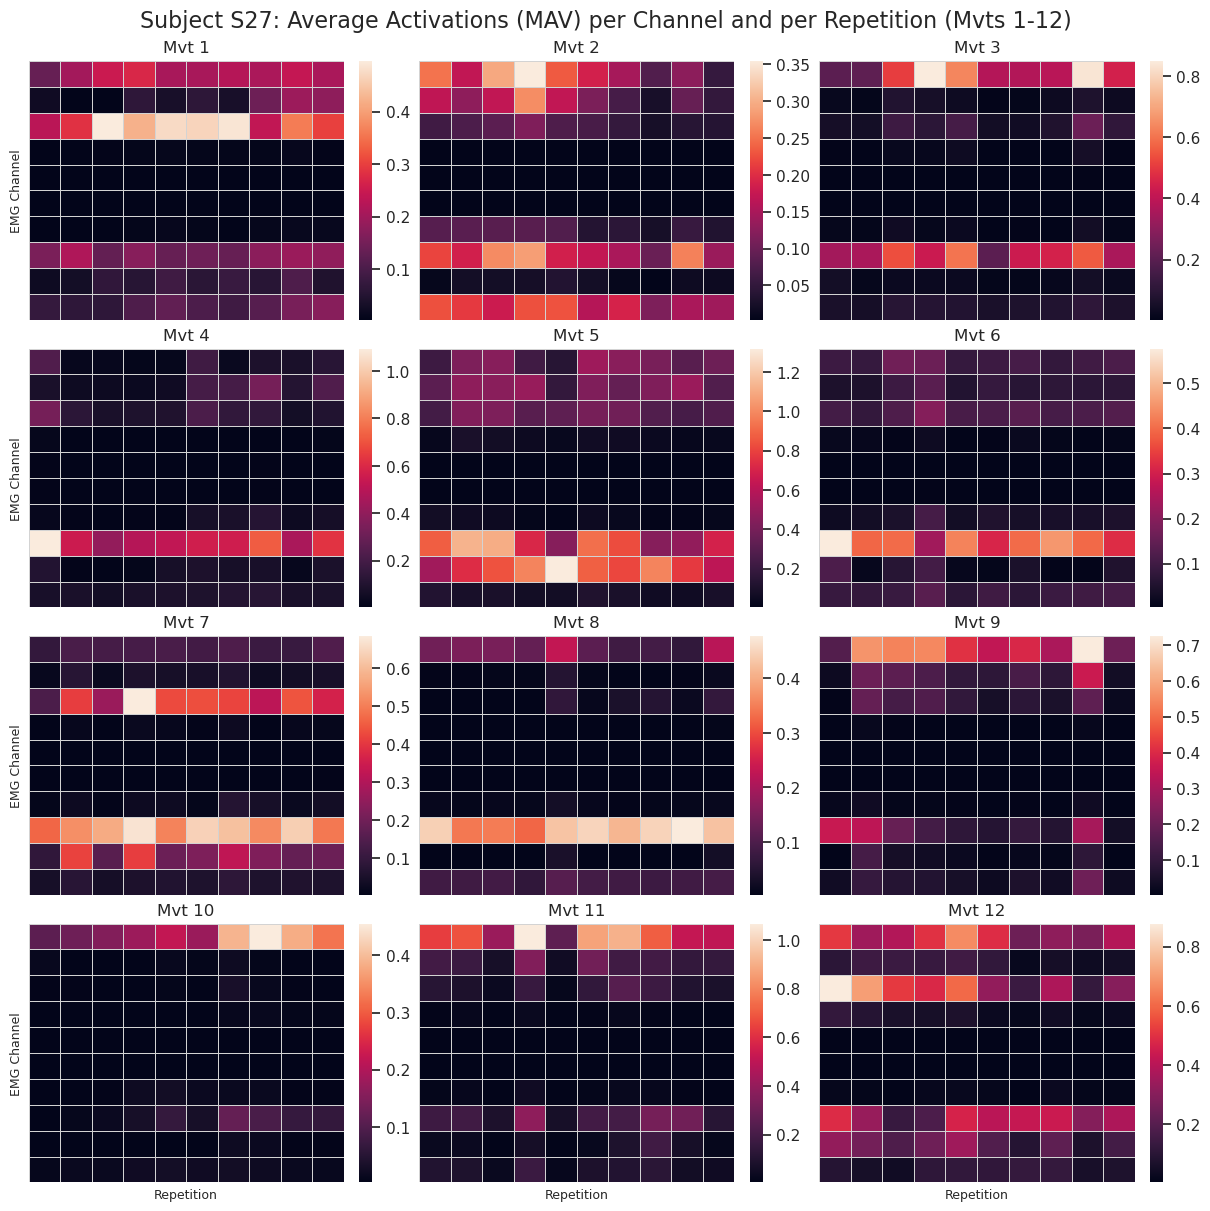

In [6]:
# Constant Ninapro DB1 A1
N_CHANNELS = 10

for subject in all_processed.keys():
    emg_envelopes = all_processed[subject]["emg_envelopes"]
    
    # Initialize the array to store average activations
    emg_average_activations = np.zeros((N_CHANNELS, N_STIMULI, N_REPETITIONS))

    # 2. Calculation of average activation
    # This is equivalent to MAV (Mean Absolute Value) calculated on the envelope
    for stimuli_idx in range(N_STIMULI):
        for repetition_idx in range(N_REPETITIONS):
            window = emg_envelopes[stimuli_idx][repetition_idx]
            
            if window is not None and window.size > 0:
                # Calculate the temporal average for each channel (axis=0)
                # Store in the array: [Channels, Movement, Repetition]
                emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(window, axis=0)
            else:
                # If the window is empty, activation remains 0
                emg_average_activations[:, stimuli_idx, repetition_idx] = 0

    # 3. Visualization of the 12 movements     
    fig, ax = plt.subplots(4, 3, figsize=(12, 12), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()
    
    for plot_idx in range(N_STIMULI):

        # Squeezing to get a 2D array: (Channels, Repetitions) for the current stimulus
        data_to_plot = emg_average_activations[:, plot_idx, :]
        
        # Creating the heatmap
        sns.heatmap(
            data_to_plot, 
            ax=ax[plot_idx], 
            xticklabels=False, 
            yticklabels=False,
            cbar=True, 
            linewidths=0.5, linecolor='lightgray'
        )
        # Title: "Mvt " + str(plot_idx + 1) -> "Mvt " + str(plot_idx + 1)
        ax[plot_idx].title.set_text("Mvt " + str(plot_idx + 1))
        ax[plot_idx].tick_params(labelsize=8)
        
        # Labels only on the first column and last row to avoid clutter
        if plot_idx % 3 == 0:
            # Set Y-label: "EMG Channel"
            ax[plot_idx].set_ylabel("EMG Channel", fontsize=9)
        if plot_idx >= 9:
            # Set X-label: "Repetition"
            ax[plot_idx].set_xlabel("Repetition", fontsize=9)
        else:
            # Remove label for others:
            ax[plot_idx].set_xlabel("")
    
    # General title for the figure
    plt.suptitle(f"Subject {subject}: Average Activations (MAV) per Channel and per Repetition (Mvts 1-12)", fontsize=16)
    plt.show()

#

## 2) Split data and extract features

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Definition
# All functions must take an array (EMG window) of shape (Timepoints, Channels)
# and return an array of shape (Channels,)

# Mean Absolute Value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0) 
# Maximum Absolute Value (MaxAV) - Peak Value
maxav = lambda x: np.max(np.abs(x), axis=0) 
# Root Mean Square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform Length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope Sign Changes (SSC) - Counts the number of times the slope changes sign (only > 0)
ssc = lambda x: np.sum(((x[1:-1] - x[:-2]) * (x[1:-1] - x[2:]) > 0), axis=0)


FEATURE_SET = [mav, std, maxav, rms, wl, ssc] 
FEATURE_NAMES = ["MAV", "STD", "MaxAV", "RMS", "WL", "SSC"]

def build_dataset_from_ninapro(emg, stimuli, repetition, features):

    n_stimuli_all = np.unique(stimuli).size 
    
    # Assuming Stimulus ID 0 is rest, so we subtract 1
    n_stimuli = n_stimuli_all - 1
    
    # Assuming Repetition ID 0 is rest/initial phase, so we subtract 1
    n_repetitions = np.unique(repetition).size - 1
    
    n_samples = n_stimuli * n_repetitions
    n_channels = emg.shape[1]
    n_features_total = sum(n_channels for feature in features)
    
    dataset = np.zeros((n_samples, n_features_total))
    
    # We store the movement labels (1 to 12)
    labels = np.zeros(n_samples) 
    
    current_sample_index = 0
    
    for i in range(n_stimuli): 
        current_stimulus_id = i + 1 # Stimulus runs from 1 to 12
        
        for j in range(n_repetitions):
            current_repetition_id = j + 1 # Repetition runs from 1 to 10
            
            # Select time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimuli == current_stimulus_id, repetition == current_repetition_id).squeeze()
            
            # We must check if the window contains data (if duration > 0)
            window_data = emg[selected_tsteps, :]
            
            if window_data.shape[0] > 0:
                # 1. Label Assignment
                labels[current_sample_index] = current_stimulus_id 
                
                current_feature_index = 0
                # 2. Feature Extraction
                for feature in features:
                    selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                    
                    # Calculate and store the feature
                    dataset[current_sample_index, selected_features] = feature(window_data)
                    
                    current_feature_index += n_channels
                    
                # 3. Move to the next sample
                current_sample_index += 1

    # Resize the arrays to the actual number of samples 
    dataset = dataset[:current_sample_index, :]
    labels = labels[:current_sample_index]
    
    return dataset, labels

In [8]:
from sklearn.preprocessing import StandardScaler

all_datasets = []
all_labels = []
all_subject_ids = []

print("--- Feature Extraction per Subject ---")
subject_scaler = StandardScaler()

for subject_id, data in all_processed.items():
    emg = data["emg"]
    # Variable 'stimulus' renamed to 'stimuli' for better English convention
    stimuli = data["stimulus"] 
    repetition = data["repetition"]
    
    # Build the dataset for the current subject
    dataset_sub, labels_sub = build_dataset_from_ninapro(
        emg=emg,
        stimuli=stimuli, # Used the renamed variable
        repetition=repetition,
        features=FEATURE_SET
    )
    
    if dataset_sub.shape[0] > 0:
        # Important: We normalize per subject !!
        dataset_sub_scaled = subject_scaler.fit_transform(dataset_sub) 

        # Append the scaled version
        all_datasets.append(dataset_sub_scaled) 
        all_labels.append(labels_sub)
        
        # Create an array with the numerical subject ID (e.g., 'S1' -> 1)
        subject_id_array = np.full(dataset_sub.shape[0], int(subject_id.replace('S', '')))
        all_subject_ids.append(subject_id_array)
        
        print(f"Subject {subject_id}: {dataset_sub.shape[0]} samples extracted and normalized (Z-score).")
    else:
        print(f"Subject {subject_id}: 0 valid samples (Skipped).")

# Final aggregation of all data
X_full = np.concatenate(all_datasets, axis=0)
y_full = np.concatenate(all_labels, axis=0)
Z_subject = np.concatenate(all_subject_ids, axis=0) # Z_subject contains the Subject ID for each sample

print(f"\n--- Aggregated Dataset ---")
print(f"X_full (Total Features): {X_full.shape}")
print(f"y_full (Total Labels): {y_full.shape}")
print(f"Z_subject (Total Subject IDs): {Z_subject.shape}")
print("-" * 40)

--- Feature Extraction per Subject ---
Subject S2: 120 samples extracted and normalized (Z-score).
Subject S1: 120 samples extracted and normalized (Z-score).
Subject S3: 120 samples extracted and normalized (Z-score).
Subject S4: 120 samples extracted and normalized (Z-score).
Subject S5: 120 samples extracted and normalized (Z-score).
Subject S6: 120 samples extracted and normalized (Z-score).
Subject S7: 120 samples extracted and normalized (Z-score).
Subject S8: 120 samples extracted and normalized (Z-score).
Subject S9: 120 samples extracted and normalized (Z-score).
Subject S10: 120 samples extracted and normalized (Z-score).
Subject S11: 120 samples extracted and normalized (Z-score).
Subject S12: 120 samples extracted and normalized (Z-score).
Subject S13: 120 samples extracted and normalized (Z-score).
Subject S14: 120 samples extracted and normalized (Z-score).
Subject S15: 120 samples extracted and normalized (Z-score).
Subject S16: 120 samples extracted and normalized (Z-sc

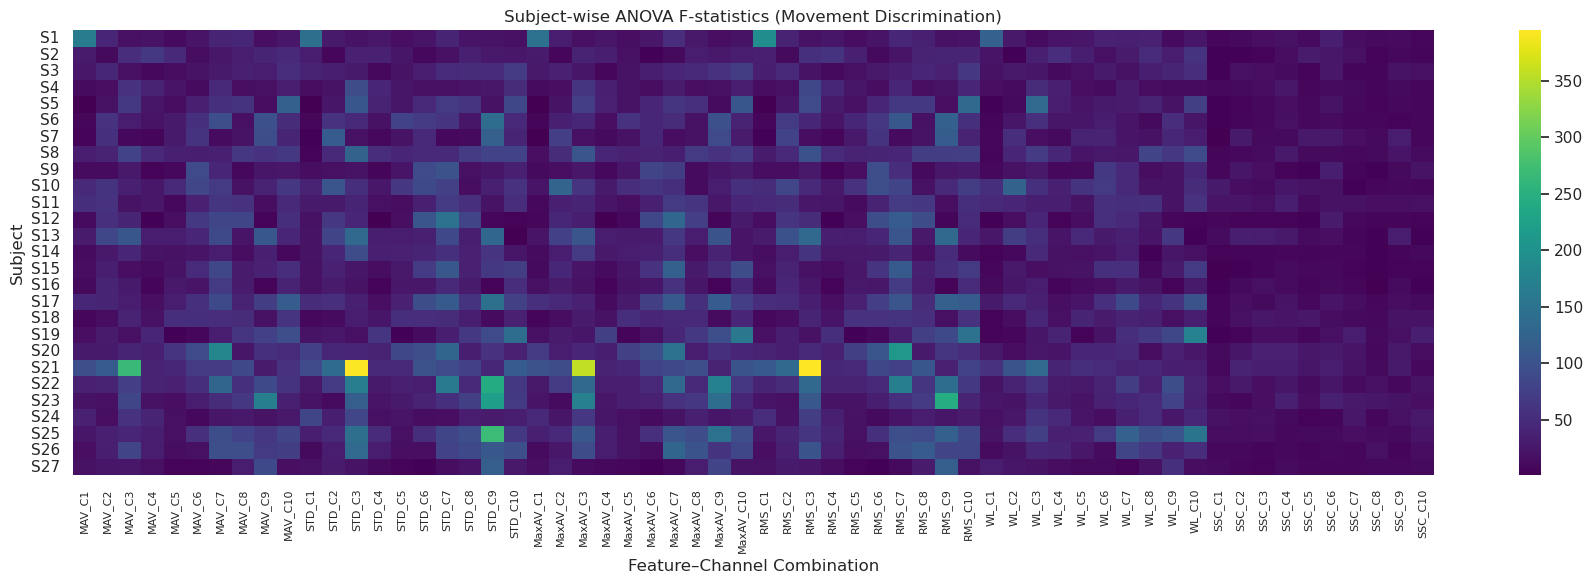

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif

# Number of subjects and total features
subject_ids = np.unique(Z_subject)
n_subjects = len(subject_ids)
n_total_features = X_full.shape[1]

# Matrix to store F-values: (subjects × feature-channel combinations)
F_subjects = np.zeros((n_subjects, n_total_features))

# --- Subject-wise ANOVA ---
for i, subj in enumerate(subject_ids):
    # Select samples from one subject
    subj_mask = Z_subject == subj
    X_subj = X_full[subj_mask]
    y_subj = y_full[subj_mask]

    # Compute ANOVA for this subject
    F_vals, _ = f_classif(X_subj, y_subj)
    F_subjects[i, :] = F_vals

# --- Reconstruct Feature–Channel names ---
feature_names_full = []
for f_name in FEATURE_NAMES:
    for c_id in range(1, N_CHANNELS + 1):
        feature_names_full.append(f"{f_name}_C{c_id}")

# --- Heatmap ---
plt.figure(figsize=(18, 6))
sns.heatmap(
    F_subjects,
    cmap="viridis",
    xticklabels=feature_names_full,
    yticklabels=[f"S{subj}" for subj in subject_ids]
)
plt.title("Subject-wise ANOVA F-statistics (Movement Discrimination)")
plt.xlabel("Feature–Channel Combination")
plt.ylabel("Subject")
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()



## 3) Train a classification model on 26 subjects

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import time

# 1. Choose the test subject
test_subject_id = 27 

param_grid = {
    "n_estimators": [40, 50, 60, 100, 150, 200],
    "max_depth": [4, 5, 6, 8, 10],
    "min_samples_split": [2, 4, 6, 8],
    "min_samples_leaf": [1, 2, 3],
    "max_features": ["log2", "sqrt"]
}


# 2. Create boolean masks based on Z_subject
mask_test = (Z_subject == test_subject_id)
mask_train = (Z_subject != test_subject_id)

# 3. Apply masks to split X and y
X_train_q3 = X_full[mask_train]
y_train_q3 = y_full[mask_train]

X_test_q3 = X_full[mask_test]
y_test_q3 = y_full[mask_test]

print(f"Test Subject: {test_subject_id}")
print(f"Train Size (26 subjects): {X_train_q3.shape}")
print(f"Test Size (1 subject): {X_test_q3.shape}")

# Base model
rf_base = RandomForestClassifier(random_state=42)

# GridSearchCV Initialization
# cv=3 means 3-fold cross-validation on the TRAIN set
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,                      
    scoring="accuracy",        
    n_jobs=-1,                 
    verbose=0                  
)

print("\n--- Starting Grid Search ---")
start_time = time.time()

# 5. Training and search for best parameters (on the TRAIN set)
grid_search.fit(X_train_q3, y_train_q3) 

end_time = time.time()
print(f"Grid Search execution time: {end_time - start_time:.2f} seconds")
print("-" * 50)

# Retrieve the best model found by the Grid Search
best_clf = grid_search.best_estimator_

print("Best parameters found:", grid_search.best_params_)
print(f"Best CV Accuracy (on Train): {grid_search.best_score_:.4f}")

# --- Evaluation on the Test Subject  ---
acc_q3_tuned = best_clf.score(X_test_q3, y_test_q3)

print("\n--- Final Model Evaluation ---")
print(f"Accuracy on Subject {test_subject_id} (new subject): {acc_q3_tuned:.4f}")

Test Subject: 27
Train Size (26 subjects): (3120, 60)
Test Size (1 subject): (120, 60)

--- Starting Grid Search ---
Grid Search execution time: 335.88 seconds
--------------------------------------------------
Best parameters found: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 150}
Best CV Accuracy (on Train): 0.4317

--- Final Model Evaluation ---
Accuracy on Subject 27 (new subject): 0.3833


## Question 4

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

print("\n--- Question 4: Leave-One-Subject-Out Cross-Validation ---")

unique_subjects = np.unique(Z_subject)
accuracies = []

# Model (Use the best parameters found in your previous GridSearch)
rf_params = {
    'n_estimators': 150,     # Example from your GridSearch
    'max_depth': 10,         # Example
    "min_samples_split": 8,  # Minimum number of samples required to split an internal node
    "max_features": 'log2',
    'min_samples_leaf': 1,
    'n_jobs': -1,
    'random_state': 42
}

# Initialize the scaler once (it will be re-initialized and fit inside the loop)
scaler = StandardScaler() 

for sub_id in unique_subjects:
    # --- A. Splitting ---
    mask_test = (Z_subject == sub_id)
    mask_train = ~mask_test # The inverse of the test mask (all other subjects)
    
    X_train_cv = X_full[mask_train]
    y_train_cv = y_full[mask_train]
    
    X_test_cv = X_full[mask_test]
    y_test_cv = y_full[mask_test]
    
    # --- C. Training ---
    clf = RandomForestClassifier(**rf_params)
    # Use the scaled training data
    clf.fit(X_train_cv, y_train_cv) 
    
    # --- D. Prediction and Score ---
    # Use the scaled test data
    y_pred = clf.predict(X_test_cv) 
    acc = accuracy_score(y_test_cv, y_pred)
    
    accuracies.append(acc)
    print(f"Fold (Test Subject {sub_id}) -> Accuracy: {acc:.4f}")

# --- E. Overall Results ---
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print("-" * 30)
print(f"Mean Accuracy over {len(unique_subjects)} folds: {mean_acc:.4f}")
print(f"Standard Deviation (StDev): {std_acc:.4f}")
print(f"Min Accuracy: {np.min(accuracies):.4f} (Subject {unique_subjects[np.argmin(accuracies)]})")
print(f"Max Accuracy: {np.max(accuracies):.4f} (Subject {unique_subjects[np.argmax(accuracies)]})")


--- Question 4: Leave-One-Subject-Out Cross-Validation ---
Fold (Test Subject 1) -> Accuracy: 0.5583
Fold (Test Subject 2) -> Accuracy: 0.1250
Fold (Test Subject 3) -> Accuracy: 0.4750
Fold (Test Subject 4) -> Accuracy: 0.3500
Fold (Test Subject 5) -> Accuracy: 0.5083
Fold (Test Subject 6) -> Accuracy: 0.3750
Fold (Test Subject 7) -> Accuracy: 0.3583
Fold (Test Subject 8) -> Accuracy: 0.5167
Fold (Test Subject 9) -> Accuracy: 0.4083
Fold (Test Subject 10) -> Accuracy: 0.3833
Fold (Test Subject 11) -> Accuracy: 0.3333
Fold (Test Subject 12) -> Accuracy: 0.5167
Fold (Test Subject 13) -> Accuracy: 0.3917
Fold (Test Subject 14) -> Accuracy: 0.4000
Fold (Test Subject 15) -> Accuracy: 0.5333
Fold (Test Subject 16) -> Accuracy: 0.4000
Fold (Test Subject 17) -> Accuracy: 0.6500
Fold (Test Subject 18) -> Accuracy: 0.4083
Fold (Test Subject 19) -> Accuracy: 0.4083
Fold (Test Subject 20) -> Accuracy: 0.4833
Fold (Test Subject 21) -> Accuracy: 0.5000
Fold (Test Subject 22) -> Accuracy: 0.4167
Fol

In [ ]:
## Question 5


--- Question 5: Impact of Training Set Size ---
Test Set: Subject 25 (120 samples)
Training with 1 subject(s) (Added S1) -> Test Acc: 0.2750
Training with 2 subject(s) (Added S2) -> Test Acc: 0.3000
Training with 3 subject(s) (Added S3) -> Test Acc: 0.3167
Training with 4 subject(s) (Added S4) -> Test Acc: 0.4000
Training with 5 subject(s) (Added S5) -> Test Acc: 0.5583
Training with 6 subject(s) (Added S6) -> Test Acc: 0.5167
Training with 7 subject(s) (Added S7) -> Test Acc: 0.5417
Training with 8 subject(s) (Added S8) -> Test Acc: 0.5583
Training with 9 subject(s) (Added S9) -> Test Acc: 0.5083
Training with 10 subject(s) (Added S10) -> Test Acc: 0.5083
Training with 11 subject(s) (Added S11) -> Test Acc: 0.5583
Training with 12 subject(s) (Added S12) -> Test Acc: 0.5500
Training with 13 subject(s) (Added S13) -> Test Acc: 0.5667
Training with 14 subject(s) (Added S14) -> Test Acc: 0.5500
Training with 15 subject(s) (Added S15) -> Test Acc: 0.5500
Training with 16 subject(s) (Added

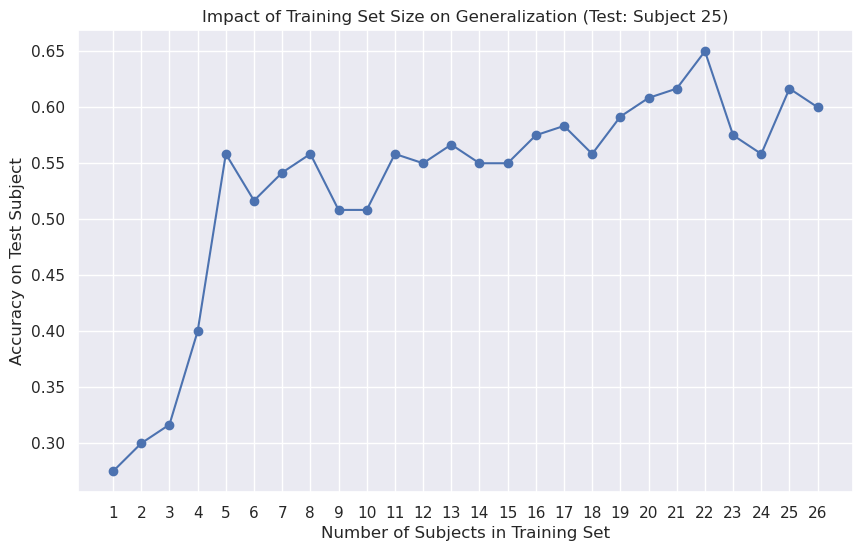

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

print("\n--- Question 5: Impact of Training Set Size ---")

# 1. Define Fixed Test Subject
test_subject_id = 25
mask_test = (Z_subject == test_subject_id)
X_test_fixed = X_full[mask_test]
y_test_fixed = y_full[mask_test]

print(f"Test Set: Subject {test_subject_id} ({X_test_fixed.shape[0]} samples)")

# 2. Define pool of training subjects (Subjects 1 to 26)
train_pool_ids = np.unique(Z_subject[Z_subject != test_subject_id])
# Sort them to ensure we add them in order (1, then 1+2, etc.)
train_pool_ids.sort()

accuracies_by_size = []
training_sizes = []


rf_params = {
    'n_estimators': 150,     # Example from your GridSearch
    'max_depth': 10,         # Example
    "min_samples_split": 8,  # Minimum number of samples required to split an internal node
    "max_features": 'log2',
    'min_samples_leaf': 1,
    'n_jobs': -1,
    'random_state': 42
}

# 3. The Loop: Accumulate subjects
current_train_mask = np.zeros(len(Z_subject), dtype=bool)

for i, subject_to_add in enumerate(train_pool_ids):
    # Add the new subject to the current training mask
    # We use logical OR to add the new subject's indices to the existing mask
    mask_new_subject = (Z_subject == subject_to_add)
    current_train_mask = current_train_mask | mask_new_subject
    
    # Extract current training data
    X_train_current = X_full[current_train_mask]
    y_train_current = y_full[current_train_mask]

    
    # --- Train Model ---
    clf = RandomForestClassifier(**rf_params)
    clf.fit(X_train_current, y_train_current)
    
    # --- Evaluate ---
    acc = clf.score(X_test_fixed, y_test_fixed)
    accuracies_by_size.append(acc)
    training_sizes.append(i + 1) # Number of subjects
    
    print(f"Training with {i+1} subject(s) (Added S{subject_to_add}) -> Test Acc: {acc:.4f}")

# 4. Visualization
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, accuracies_by_size, marker='o', linestyle='-', color='b')
plt.title(f'Impact of Training Set Size on Generalization (Test: Subject {test_subject_id})')
plt.xlabel('Number of Subjects in Training Set')
plt.ylabel('Accuracy on Test Subject')
plt.grid(True)
plt.xticks(training_sizes) # Show all numbers on x-axis
plt.show()